# Progetto machine learning

## Obiettivi
Obiettivo del progetto è la sperimentazione di vari modelli di classificazione in grado di riconoscere generi musicali. Lo sviluppo del progetto è suddiviso in due sezioni:
- Nella prima sezione si addestreranno e testeranno modelli sulla base di un insieme di dati che sono stati pre-calcolati e offerti da Free Music Archive (FMA). FMA è un archivio "open" che offre gratuitamente accesso ad una vasta gamma di audio appartenenti a vari generi.

- La seconda sezione si prefigge di effettuare una classificazione di un brano musicale a partire dal suo spettrogramma. Quindi in questa sezione verrà creato un nuovo dataset a partire dagli audio scaricati da FMA. Gli audio scaricati sono infatti convertiti in immagini ,che rappresentano lo spettrogramma dell'audio, e che verranno successivamente utilizzate per addestrare e testare una rete convoluzionale. Di conseguenza non si farà uso di dati già pre-calcolati, ma verranno generati da zero.

## Prima sezione
In questa prima sezione la sperimentazione ha come obiettivo quello di confrontare tre modelli di classifiazione:
1. SVM
2. Gaussian Naive Bayes
3. Random Forest
4. KNN
5. ADA Boost

Ogni modello sarà soggetto ad una model selection per individuare i parametri che massimizzano l'accuratezza. Il confronto dei modelli si baserà invece sull'analisi di alcune metriche quali:

1. Precisione
2. Recall
3. Accuratezza
4. F1
5. AUC


Per la realizzazione del progetto si importano una serie di librerie e funzioni utili.

In [1]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.decomposition, sklearn.svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import utils
import dotenv
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
import multiprocessing.sharedctypes as sharedctypes
import os.path
import ast
import warnings
import matplotlib 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import copy


warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (17, 5)

NB_AUDIO_SAMPLES = 1321967
SAMPLING_RATE = 44100

dotenv.load_dotenv(dotenv.find_dotenv())

def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'

    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


def plot_matrix_confusion(clf,X_test,y_test,title):
    y_pred = clf.predict(X_test)

    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_test, y_pred)

    # Definizione delle etichette delle classi
    class_labels = np.unique(np.concatenate((y_test, y_pred)))

    # Plot della matrice di confusione
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    # Aggiunta dei valori all'interno della matrice di confusione
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.xlabel('Etichette Predette')
    plt.xticks(rotation=90)

    plt.ylabel('Etichette Vere')
    plt.tight_layout()
    plt.show()

    

## Dati
I dati scaricati da FMA e utilizzati per questo progetto sono raccolti in due csv che verrano utilizzati in maniera combinata:
- tracks.csv : mantiene informazioni relative ai metadati degli audio.
- features.csv : mantiene un set di features pre-calcolate e che descrivono da un punto di vista statistico gli audio. 

Combinando le informazioni provenienti da entrambi i csv è possibile ricavare un dataset completo con featutures e valori target.

In [2]:

# caricamento features e target
tracks = load('data/fma_metadata/tracks.csv')
features = load('data/fma_metadata/features.csv')

tracks.shape, features.shape

((106574, 52), (106574, 518))

Nel file track.csv sono mantenute informaizioni relative :
- **all'album di appartenenza** di un audio. In particolare viene specificato la data di creazione dell'album, il produttore, il titolo, il tipo,commenti etc.
- al suo **autore**. In particolare viene specificata la biografia, il suo sito web, la sua pagina wikipedia etc.
- informazioni generiche sull'**audio**. In particolare viene specificato la lingua, la licenza , il titolo, il bit rate, il genere.. etc.

Tutti i nomi delle features sono mostrati in basso. Osservando questi attributi appare evidente che si tratti solo di informazioni di contorno, che quasi sicuramente non sono utili ad un classificatore per effettuare delle predizioni. Di queste informazioni gli unici dati di interesse sono l'id dell'audio e il suo genere. Queste informazioni infatti combinate ai dati presenti in features.csv permettono la creazione di un dataset completo in cui è possibile associare a delle entry un target specifico. Tutti gli altri dati di questo csv non verranno presi in considerazione.


In [3]:
print(tracks.columns)

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          


Il file features.csv contiene informazioni relative a 10 features calcolate tramite librosa. In particolare per ogni feature sono mantenute statistiche come media, varianza , curtosi, massimo e minimo. Le 10 features sono:
- **spectral_bandwidth**: La larghezza di banda spettrale si riferisce all'estensione di frequenza occupata da un segnale o da una componente di frequenza all'interno dello spettro. Indica quanto spazio occupa il segnale nello spettro delle frequenze.
- **spectral_centroid**: centro di massa dello spettro.
- **spectral_contrast** : Lo spectral contrast (contrasto spettrale) è una misura che descrive la differenza di energia tra i picchi spettrali e i valori di fondo dello spettro di un segnale audio. 
- **spectral_rolloff** : Spectral rolloff (rolloff spettrale) è una misura utilizzata per descrivere la pendenza o la frequenza di taglio superiore dello spettro di un segnale audio. Indica la frequenza al di sopra della quale si trova una certa percentuale di energia spettrale totale.
- **chroma_cens** :  Chroma Energy Normalized (CENS) è una rappresentazione utilizzata per l'analisi degli spettri musicali. È una variante del Chroma Energy Normalization (CEN), che mira a fornire una rappresentazione robusta delle caratteristiche tonali di un brano musicale.
- **chroma_cqt** : Il Constant-Q Chromagram è una rappresentazione spettrale di un segnale audio che cattura le informazioni sulle componenti tonali in modo simile al Chroma Energy Normalized (CENS), ma utilizza una trasformata di Fourier a tempo breve a risoluzione costante (Constant-Q Transform) anziché la tradizionale STFT.
La trasformata di Fourier a tempo breve (STFT) viene generalmente utilizzata per ottenere la rappresentazione spettrale di un segnale audio, ma ha una risoluzione costante in termini di frequenza. Ciò significa che la distanza tra le frequenze è costante in tutta la scala dello spettro audio. Tuttavia, l'orecchio umano percepisce le frequenze in modo logaritmico, il che significa che le differenze tra le frequenze percepibili non sono costanti, ma si espandono in modo logaritmico.
Per affrontare questa differenza di percezione è utilizzata la trasformata di Fourier a tempo breve a risoluzione costante (Constant-Q Transform). Questa trasformata fornisce una risoluzione in frequenza che aumenta in modo logaritmico, in modo che le frequenze più basse abbiano una maggiore risoluzione rispetto alle frequenze più alte.
- **tonnetz** : Il tonnetz è utile per visualizzare e comprendere le relazioni tonali e armoniche. Può aiutare a identificare le progressioni di accordi, le modulazioni tonali e le relazioni di tonalità in una composizione musicale. 
- **zcr**: Zero-crossing rate (tasso di attraversamento dello zero) è una misura utilizzata per descrivere la frequenza con cui un segnale audio attraversa lo zero in un determinato intervallo di tempo. Indica il numero di volte in cui la forma d'onda del segnale cambia di segno da positivo a negativo o viceversa.
- **mfcc**: mel-frequency cepstrum è una rappresentazione dello spettro di potenza a breve termine di un suono, basato su una trasformata lineare del coseno di uno spettro di potenza logaritmica su una scala di frequenza mel non lineare .
- **rmse** 
- **chroma_stft** 


In [4]:
print(features.columns[0::6])

MultiIndex([(       'chroma_cens', 'kurtosis', '01'),
            (       'chroma_cens', 'kurtosis', '07'),
            (       'chroma_cens',      'max', '01'),
            (       'chroma_cens',      'max', '07'),
            (       'chroma_cens',     'mean', '01'),
            (       'chroma_cens',     'mean', '07'),
            (       'chroma_cens',   'median', '01'),
            (       'chroma_cens',   'median', '07'),
            (       'chroma_cens',      'min', '01'),
            (       'chroma_cens',      'min', '07'),
            (       'chroma_cens',     'skew', '01'),
            (       'chroma_cens',     'skew', '07'),
            (       'chroma_cens',      'std', '01'),
            (       'chroma_cens',      'std', '07'),
            (        'chroma_cqt', 'kurtosis', '01'),
            (        'chroma_cqt', 'kurtosis', '07'),
            (        'chroma_cqt',      'max', '01'),
            (        'chroma_cqt',      'max', '07'),
            (        'chroma

Per gli scopi di questo progetto i dati a disposizione sono stati partizionati per ottenere un dataset per la fase di training, uno per la fase di validazione e  uno invece per la fase di test. La fase di validazione verrà sfruttata per realizzare un minimo di model selection.

In [44]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]

X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test , 'mfcc']
X_val = features.loc[small & val, 'mfcc']

metrics = ["Precision", "Recall", "Accuracy", "AUC", "F1"]

print('{} training examples, {} testing examples, {} validation examples'.format(y_train.size, y_test.size,y_val.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))



6400 training examples, 800 testing examples, 800 validation examples
140 features, 8 classes


Il dataset si compone di 140 features, 8000 entry e 8 generi musicali.In particolare le 8 classi sono perfettamente bilanciate. Ci sono esattamente 1000 entry per ogni classe.

<BarContainer object of 8 artists>

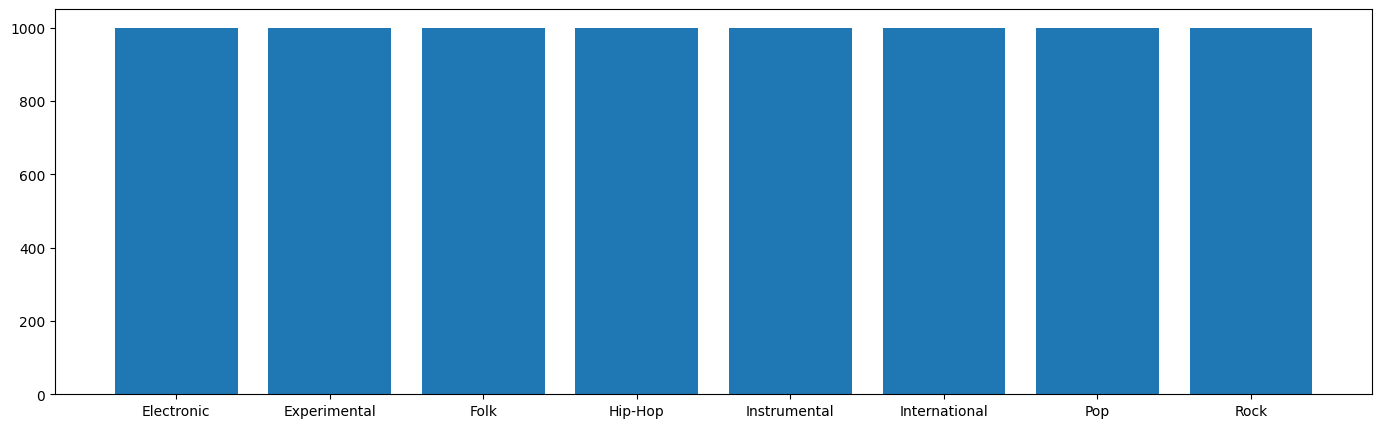

In [6]:
small = tracks['set', 'subset'] <= 'small'
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']
num_genre = []

for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name
    X = features.loc[small & (genre)]
    num_genre.append(len(X))

plt.bar(all_genre,num_genre)

Nei csv i dati sono organizzati in maniera gerarchica. Le varie colonne che compongono il dataset sono modellate da python come "multi index". Per cui se si vuole accedere ad una riga del dataset bisogna specificare una tupla di elementi che corrispondono alla feature di interesse e alla statistica calcolata su quella specifica feature(esempio : media , varianza , massimo , minimo, etc,). Avere un dataset organizzato in questo modo può rivelarsi molto scomodo soprattutto nella generazione dei grafici. Con il pezzo di codice seguente viene effettuato un appiattimento della struttura gerarchica in modo che il nome di una colonna venga modellato come una stringa che indica la coppia "feature-statistica". 

In [45]:

X_train.columns = X_train.columns.to_flat_index()
X_train.columns = [str(elem) for elem in X_train.columns]

X_test.columns = X_test.columns.to_flat_index()
X_test.columns = [str(elem) for elem in X_test.columns]

X_val.columns = X_val.columns.to_flat_index()
X_val.columns = [str(elem) for elem in X_val.columns]

for i in range(0,len(X_train.columns),20):
    print(X_train.columns[i])


('kurtosis', '01')
('max', '01')
('mean', '01')
('median', '01')
('min', '01')
('skew', '01')
('std', '01')


## Rappresentazione dei dati
Per avere un idea più chiara dei dati a disposizione è possibile effettuare un minimo di analisi statistica e graficare i dati stessi su un piano bidimensionale. Per rappresentare graficamente i dati è possibili applicare una riduzione di dimensionalità utilizzando la PCA. Si ricordi che il dataset originale ha 518 entry , per cui cercare di proiettare un punto in uno spazio a 518 dimensioni in uno a 2, comporta inevitabilmente una grande perdita di informazioni. Tuttavia questo non è un grande problema, infatti l'addestramento dei modelli di classificazione avverrà comunque con il dataset completo, la riduzione di dimensionalità in questo caso ha solo l'obiettivo di mostrare i dati. Di seguito è riportata la rappresentazione delle entry del dataset suddivisa per genere. Si può notare da questa prima immagine come i punti delle varie classi siano molto simili tra loro e per la maggior parte sono proiettati tutti nella stessa regione del piano.

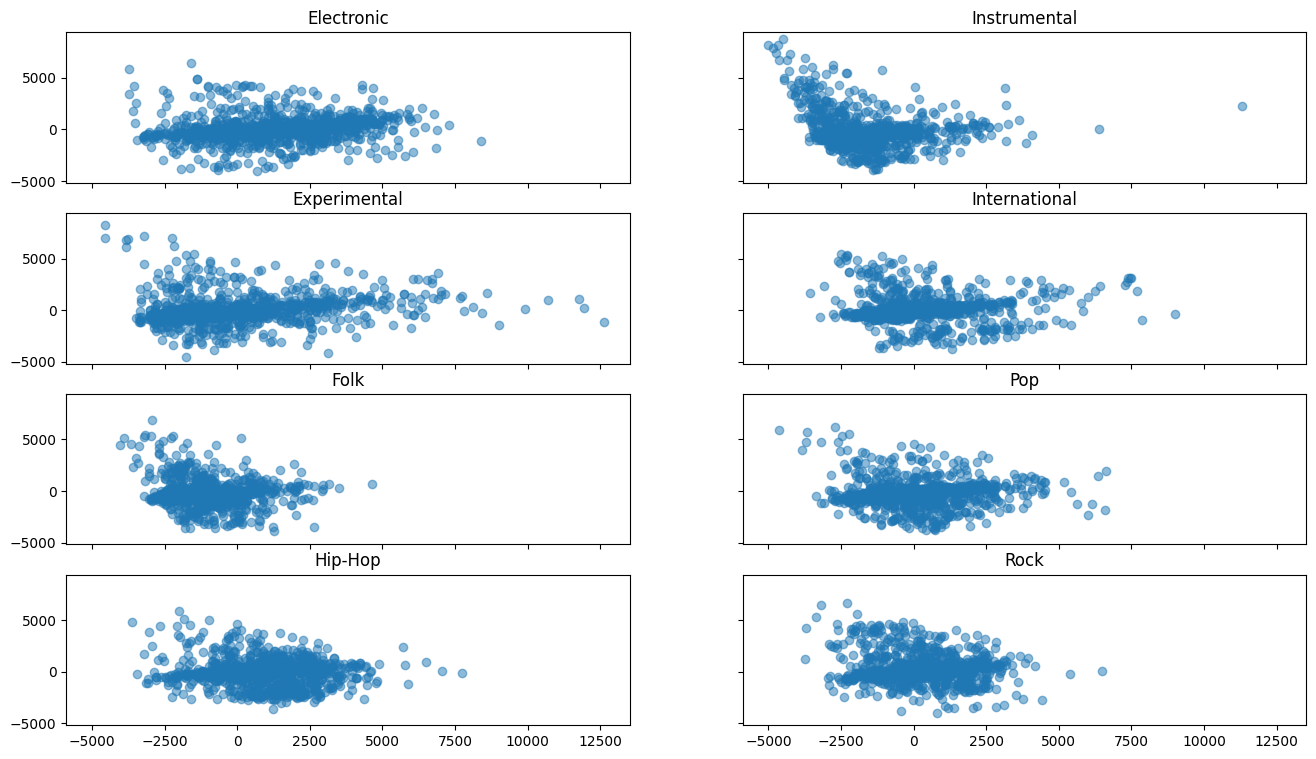

In [8]:
small = tracks['set', 'subset'] <= 'small'
f, axarr = plt.subplots(4,2,figsize=(16, 9),sharex=True, sharey=True)

all_pos_to_plot = [[0,0],[1,0],[2,0],[3,0],[0,1],[1,1],[2,1],[3,1]]
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']


#Applico riduzione dimensionalità dei dati di training
Xtot = features.loc[small]
pca = skl.decomposition.PCA(n_components=2)
pca.fit_transform(Xtot)

#Filtro il dataset per classe e lo rappresento su un piano bidimensionale
for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name
    X = features.loc[small & (genre)]
    X = pca.transform(X)

    pos_to_plot = all_pos_to_plot[pos]
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter( X[:,0], X[:,1], alpha=0.5)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(genre_name)




 Rappresentare i dati su uno spazio bidimensionale ha come obiettivo anche quello di verificare se è possibile individuare una partizione dei punti. L'immagine seguente mostra la rappresentazione di coppie di generi a confronto. Si può notare come per quasi tutte le coppie i generi appaiano poco separati e tendono quasi a sovrapporsi. Solo la coppia Instrumental - Hip-Hop è più separabile delle altre.  Invece la coppia Pop-Rock è quasi perfettamente sovrapposte tra di loro. Questo potrebbe far pensare che i modelli di classificazione possano fare molta fatica ad distinguere questi due generi. 

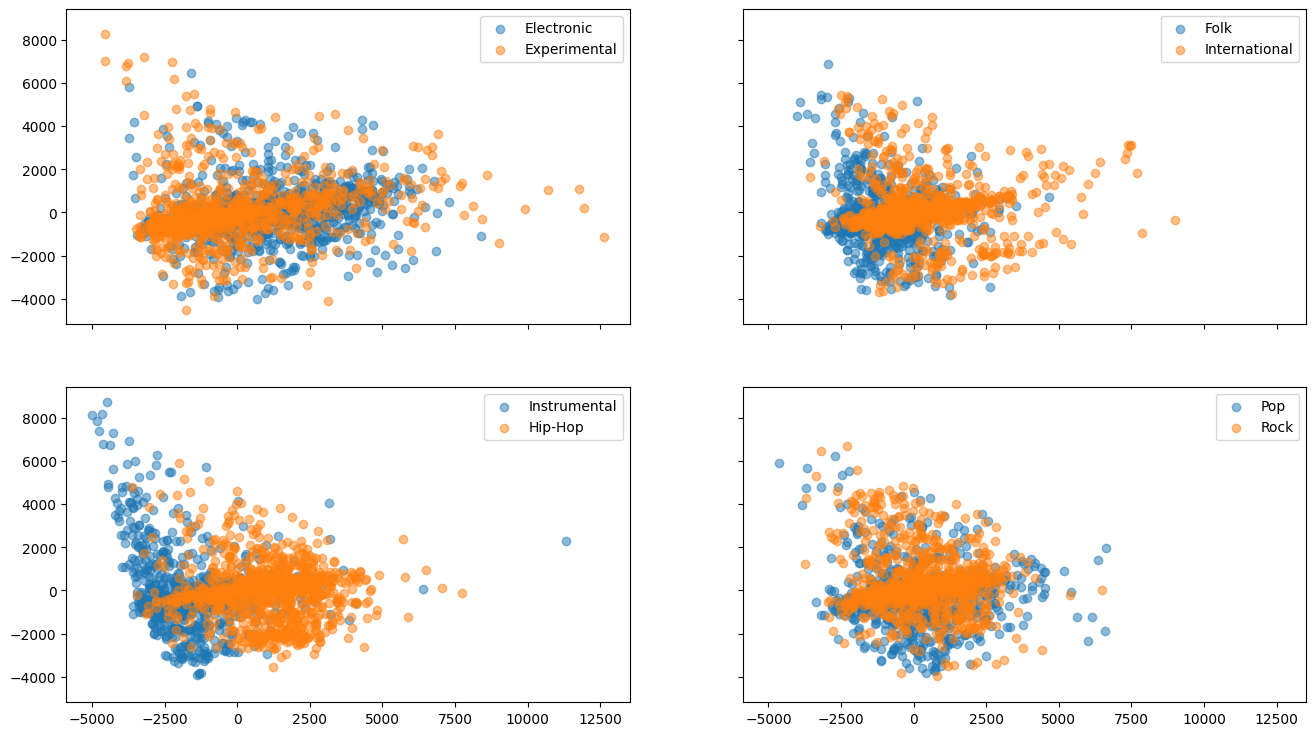

In [9]:
small = tracks['set', 'subset'] <= 'small'
all_pos_to_plot = [[0,0],[1,0],[0,1],[1,1]]
all_duo_genre = [['Electronic', 'Experimental'] , ['Instrumental' ,'Hip-Hop'] ,['Folk','International'] ,['Pop', 'Rock']]

#Applico riduzione dimensionalità dei dati di training
Xtot = features.loc[small]
pca = skl.decomposition.PCA(n_components=2)
pca.fit_transform(Xtot)

f, axarr = plt.subplots(2,2,figsize=(16, 9),sharex=True, sharey=True)

#Scorro le coppie di classi che voglio rappresentare nello stesso grafico
for pos ,duo_genre in enumerate(all_duo_genre):

    genre1 = tracks['track', 'genre_top'] == duo_genre[0]
    genre2 = tracks['track', 'genre_top'] == duo_genre[1]
 
    X = features.loc[small & (genre1)]
    X = pca.transform(X)

    X2 = features.loc[small & (genre2)]
    X2 = pca.transform(X2)

    pos_to_plot = all_pos_to_plot[pos]
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter(X[:,0], X[:,1],alpha=0.5, label=duo_genre[0])
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter(X2[:,0], X2[:,1], alpha=0.5, label=duo_genre[1])
    axarr[pos_to_plot[0]][pos_to_plot[1]].legend()
    


Si continua con l'analisi dei dati effettuando delle operazioni più dettagliate. I grafici seguenti cercano di mettere a fuoco le caratteristiche delle features in base alla classe di appartenenza. Se le features tendono ad avere caratterizzazioni diverse per ogni classe è piu semplice per un predittore ottenere prestazoni migliori. In particolare per effettuare queste analisi si vanno a cercare le 20 features più significative. La ricerca delle features migliori si basa sul concetto di varianza. Le features che hanno varianza maggiore sono le più significativa.

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)

# Applica la selezione delle feature al dataset
X_new = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]


Dopo aver individuato le 20 features più significative è possibile graficare la distribuzione della più significativa , e differenziare questa distribizione per classe di appartenenza. Quello che si può notare è che effettivamente le distribuzioni sono leggermente diverse tra loro. Hanno tutte un andamento a campana, tuttavia alcune hanno una campana piu stretta(Hip-hop) altre una piu larga(Instrumental). Allo stesso modo il valore centrale della campana è diverso da genere a genere.

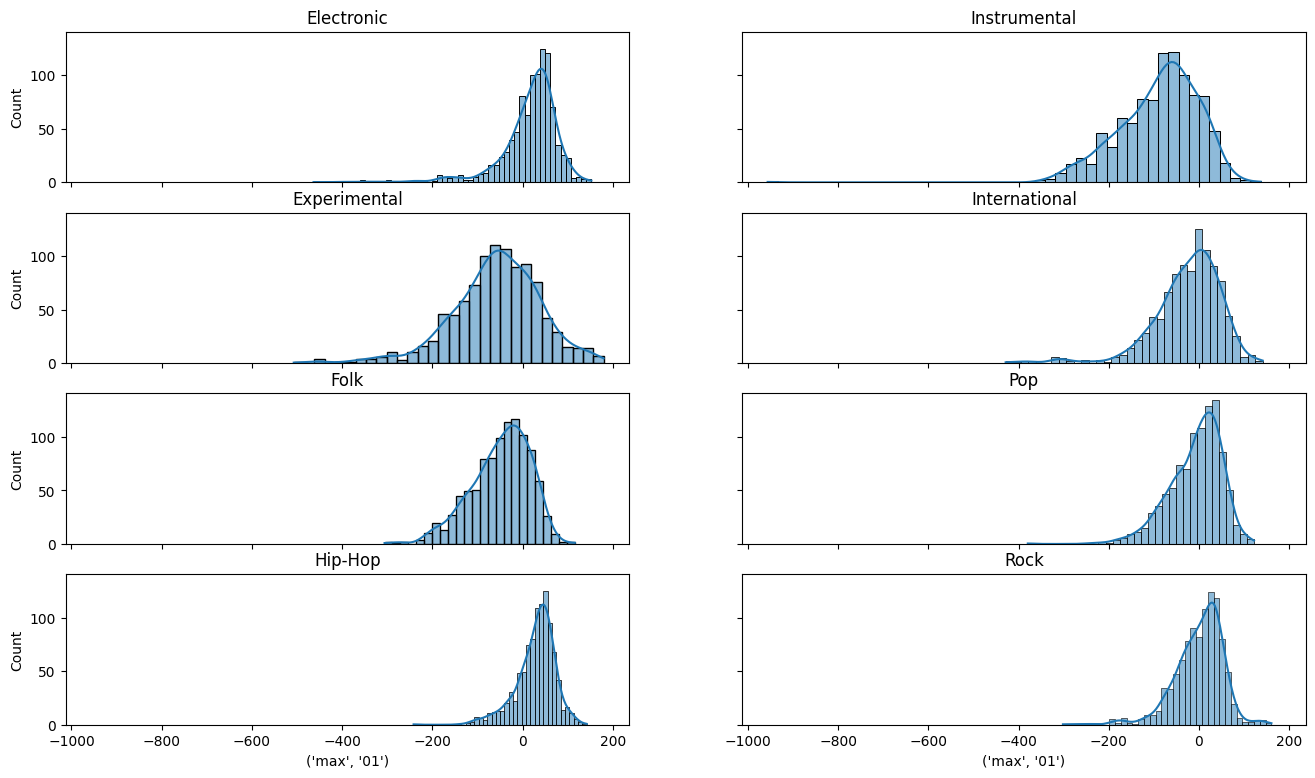

In [11]:
import seaborn as sns


small = tracks['set', 'subset'] <= 'small'
f, axarr = plt.subplots(4,2,figsize=(16, 9),sharex=True, sharey=True)
all_pos_to_plot = [[0,0],[1,0],[2,0],[3,0],[0,1],[1,1],[2,1],[3,1]]
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']

#Filtro il dataset per ogni classe 
for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name

    X = features.loc[small & (genre),  'mfcc']
    X.columns = X_train.columns.to_flat_index()
    X.columns = [str(elem) for elem in X_train.columns]

    pos_to_plot = all_pos_to_plot[pos]

    #Rappresento distribuzione della feature più significativa per ogni classe
    sns.histplot(data=X, x=selected_features[0], kde=True, ax=axarr[pos_to_plot[0]][pos_to_plot[1]])
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(genre_name)


L'analisi continua mostrando come le due features più rilevanti sono congiuntamente connesse tra loro. Quello che si può notare è che le features hanno una distribuzione a campana nello spazio uni/bi - dimensionale. Poichè le features hanno tutte una distribuzione a campana si potrebbe già pensare che il classificatore Gaussian naive Bayes possa ottenere delle prestazioni migliori, in quanto la distribuzione gaussiana può essere un ottima approssimazioni per la distrubuzioni delle features.

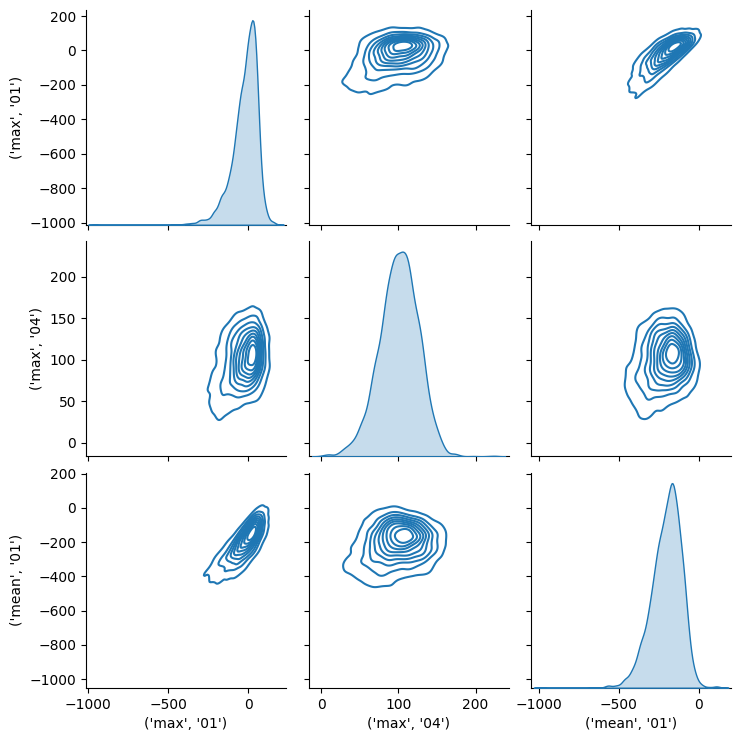

In [12]:

df = pd.DataFrame(X_new,columns=selected_features)
sns.pairplot(data=df, kind="kde",vars=selected_features[:3])

Infine è mostrata anche una matrice di correlazione per vedere come tutte le features sono collegate tra loro. Si può notare che in generale non c'è una fortissima correlazione se non per alcune coppie di features. Si osserva una forte correlazione ad esempio per le features che descrivono un audio nel dominio della frequenza come spectral rolloff , spectral bandwidt, spectral centroid. Il fatto che siano così correlate potrebbe far pensare che siano features portatrici della stessa informazione , e che quindi non sia utilissimo utilizzare tutti questi attributi nella fase di addestramento del modello.

<Axes: >

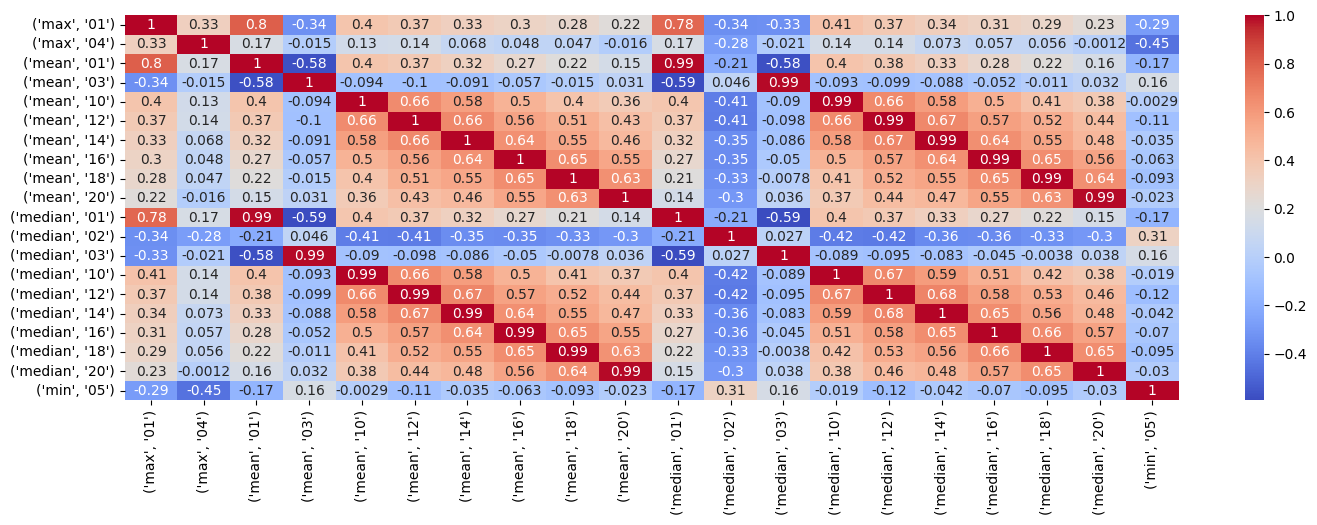

In [13]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


## In sintesi
- Il dataset è formato da 8000 entry e 8 classi
- Il dataset è perfettamente bilanciato
- Il dataset è formato da 140 features
- I punti del dataset appaiono poco linearmente separabili
- Le features del dataset non sono fortemente correlate
- Le features più significative hanno una distrubuziona a campana


## Model selection

### SVM
SVM (Support Vector Machine), è un algoritmo basato su approccio supervisionato utilizzato per la classificazione e la regressione. Nella libreria sklearn, SVM fornisce diverse funzioni kernel per effettuare la trasformazione dei dati per consentire la classificazione  in un nuovo spazio di proiezione. Queste funzioni kernel sono specificate come parametri nell'implementazione SVM di sklearn.
I kernel più comunemente utilizzati sono:

1.  Sigmoid Kernel: Il kernel sigmoide trasforma i dati in uno spazio di dimensionalità superiore. L'idea è che proiettando i dati un uno spazio a dimensionalità superiore sia più semplice per un predittore effettuare il partizionamento e ottimizzare le prestazioni. La funzione kernel sigmoide è definita come:

    $$K(x, y) = tanh(gamma * <x, y> + coef0)$$

    dove <x, y> rappresenta il prodotto scalare tra i vettori x e y. Gamma e coef0 sono parametri che possono essere specificati quando si crea il modello SVM con il kernel sigmoide. La funzione sigmoide è simile alla funzione di attivazione sigmoide utilizzata nelle reti neurali ed è particolarmente utile per il supporto della classificazione binaria.

2. Radial Basis Function (RBF) Kernel: Il kernel RBF è uno dei più utilizzati. La funzione kernel RBF è definita come:

    $$K(x, y) = exp(-gamma * ||x - y||^2)$$

    dove ||x - y||^2 rappresenta la distanza euclidea al quadrato tra i vettori x e y. Gamma è un parametro che regola l'influenza dei singoli punti di addestramento nel calcolo del confine decisionale. Valori più grandi di gamma possono portare a un modello SVM più aderente ai dati di addestramento, potenzialmente causando overfitting.

3. Polynomial Kernel: Il kernel polinomiale trasforma i dati in uno spazio di dimensionalità superiore utilizzando una funzione polinomiale. La funzione kernel polinomiale è definita come:

    $$K(x, y) = (gamma * <x, y> + coef0)^{degree}$$

    dove <x, y> rappresenta il prodotto scalare tra i vettori x e y. Gamma, coef0 e degree sono parametri che possono essere specificati quando si crea il modello SVM con il kernel polinomiale. Degree controlla il grado del polinomio utilizzato per la trasformazione dei dati.

Nella ricerca del modello migliore gamma e coef0 verranno mantenuti i valori di default, si agirà invece sul modificare il kernel, il fattore C di regolarizzazione e sul grado nel caso di kernel polinomiale.

Il codice seguente addestra tre modelli utilizzando una diversa tipologia di kernel, mantenendo ovunque i valori di defaul. Dal grafico delle prestazioni(accuratezza) dei tre modelli addestrati, si può osservare  come i kernel "rbf","poly" hanno prestazioni paragonabili. Ha senso quindi procedere la model selection utilizzando in particolare questi due modelli.

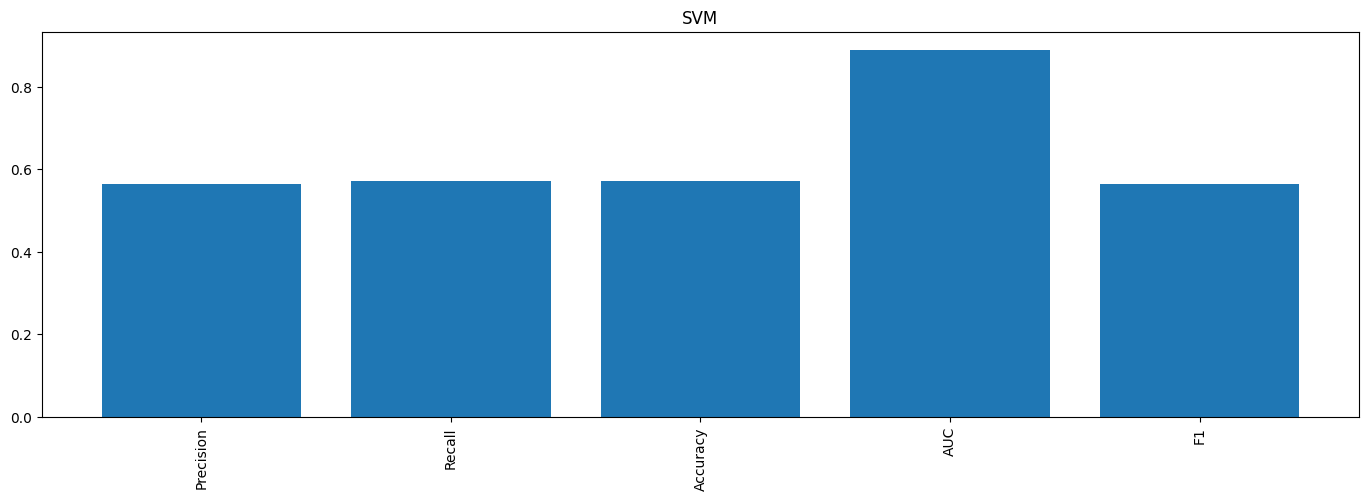

In [14]:

param_grid = {
    'C': np.arange(1, 6, 0.1),
    'kernel': [ 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree':  range(5),
    'coef0' : np.arange(0, 1, 0.2),
    'decision_function_shape' : ["ovo","ovr"]
}


nomi_colonne = ['C','precision','recall','accuracy','f1','AUC','kernel','degree']
df_SVM = pd.DataFrame(columns=nomi_colonne)
df_SVM.to_csv("SVM.csv")

metrics_best = []

label_binarizer = LabelBinarizer()
clf_best_SVM = None

best_accuracy = 0
best_precision = 0
best_recall = 0
best_AUC = 0
best_F1 = 0


for kernel in param_grid['kernel']:
    for c in param_grid['C']:
        for gamma in param_grid['gamma']:
            for degree in param_grid['degree']:
                for coef0 in param_grid['coef0']:

                        # Support vector classification.
                        clf = skl.svm.SVC(kernel=kernel, C=c, gamma=gamma, degree=degree, coef0=coef0, probability=True)
                        clf.fit(X_train, y_train)

                        y_pred=clf.predict(X_train)
                        y_pred_proba=clf.predict_proba(X_train)
                        
                        accuracy = accuracy_score(y_train, y_pred)
                        f1 = f1_score(y_train, y_pred, average='macro')
                        precision = precision_score(y_train, y_pred,average='macro')
                        recall = recall_score(y_train, y_pred,average='macro')

                        true_labels_binary = label_binarizer.fit_transform(y_train)
                        roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

                        if accuracy>best_accuracy:
                            metrics_best = []
                            metrics_best.append(precision)
                            metrics_best.append(recall)
                            metrics_best.append(accuracy)
                            metrics_best.append(roc_auc)
                            metrics_best.append(f1)
                            clf_best_SVM = copy.deepcopy(clf)
                            best_accuracy = accuracy
                        
                        new_row = {
                            'C': c,
                            'precision': precision,
                            'recall': recall,
                            'accuracy': accuracy,
                            'f1': f1,
                            'AUC': roc_auc,
                            'kernel':kernel,
                            'degree':degree
                        }

                        df_SVM.loc[len(df_SVM)] = new_row
                        df_SVM.to_csv("SVM.csv")

plt.bar(metrics, metrics_best)
plt.title("SVM")
plt.xticks(rotation=90)
plt.show()

                        




Dopo aver trovato il modello migliore è possibile osservare gli errori commessi attraverso la visualizzazione della matrice di confusione. In accordo ai valori delle metriche trovate il classificatore migliore si comporta molto male. Riconosce correttamente quasi tutti i generi. Experimental e Pop invece non vengono riconosciuti molto bene.


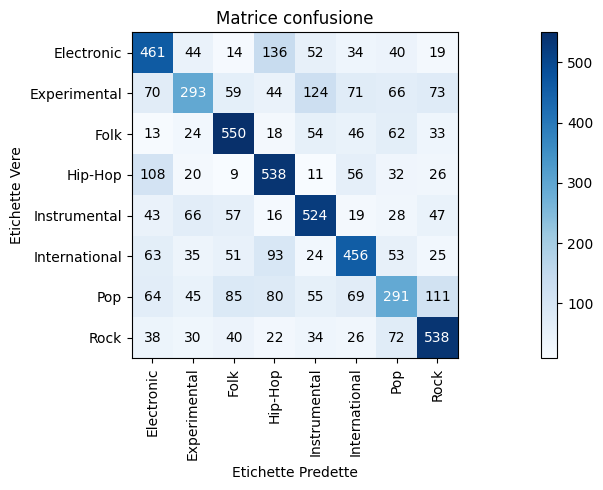

In [15]:
plot_matrix_confusion(clf_best_SVM,X_train,y_train,"Matrice confusione")

Di seguito sono riportate 3 immagini che mostrano come le metriche di accuratezza, precisione e f1 variano al variare del fattore di regolarizzazione. Si può notare come per i modelli caratterizzati da un kernel polinomiale o rbf, l'aumentare del fattore di regolarizzazione comporta un miglioramento delle prestazioni. Fenomeno he non si verifica invece nei modelli caratterizzati dal kernel sigmoide.

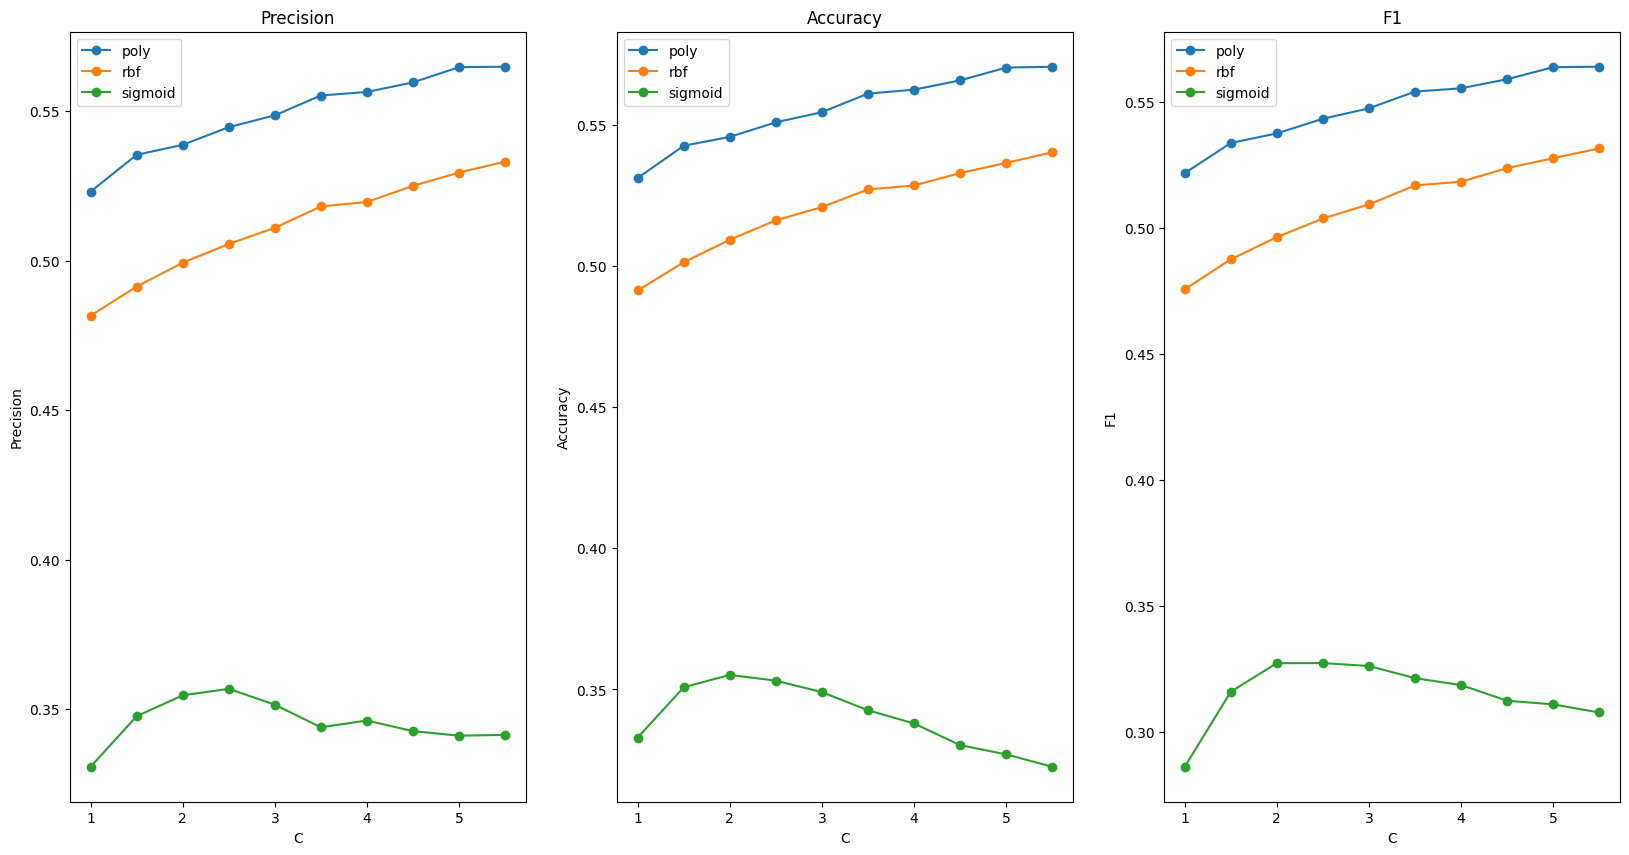

In [42]:


df_SVM = pd.read_csv('SVM.csv')
df_poly_3 = df_SVM[ (df_SVM['kernel'] == "poly") & (df_SVM['degree'] == 3)] 
df_sigmoid = df_SVM[ (df_SVM['kernel'] == "sigmoid")]
df_rbf = df_SVM[ (df_SVM['kernel'] == "rbf") & (df_SVM['degree'] == 3)] 

f, axarr = plt.subplots(1,3,figsize=(20, 10))

axarr[0].set_title("Precision")
axarr[0].set_xlabel("C")
axarr[0].set_ylabel("Precision")
axarr[0].plot(df_poly_3['C'],df_poly_3['precision'], '-o', label="poly")
axarr[0].plot(df_rbf['C'],df_rbf['precision'], '-o', label="rbf")
axarr[0].plot(df_sigmoid['C'],df_sigmoid['precision'], '-o', label="sigmoid")
axarr[0].legend()

axarr[1].set_title("Accuracy")
axarr[1].set_xlabel("C")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(df_poly_3['C'],df_poly_3['accuracy'], '-o',label="poly")
axarr[1].plot(df_rbf['C'],df_rbf['accuracy'], '-o',label="rbf")
axarr[1].plot(df_sigmoid['C'],df_sigmoid['accuracy'], '-o', label="sigmoid")
axarr[1].legend()

axarr[2].set_title("F1")
axarr[2].set_xlabel("C")
axarr[2].set_ylabel("F1")
axarr[2].plot(df_poly_3['C'],df_poly_3['f1'], '-o',label="poly")
axarr[2].plot(df_rbf['C'],df_rbf['f1'], '-o',label="rbf")
axarr[2].plot(df_sigmoid['C'],df_sigmoid['f1'], '-o', label="sigmoid")
axarr[2].legend()







### Gaussian naive bayes
I classificatori Gaussian Naive Bayes sono un tipo di algoritmo di classificazione probabilistica basato sul teorema di Bayes con l'assunzione di indipendenza condizionale gaussiana. Questi classificatori sono spesso utilizzati per problemi di classificazione quando le variabili di input sono continue e possono essere approssimate da una distribuzione gaussiana (distribuzione normale). In questo caso, data la distribuzione delle feature, ci si aspetta che possano avere delle prestazioni accettabili.
Il classificatore Gaussian Naive Bayes si basa sull'ipotesi di indipendenza condizionale, il che significa che assume che tutte le variabili di input siano indipendenti tra loro dato il valore dell'etichetta di classe. Questa assunzione semplifica il calcolo della probabilità condizionale e semplifica l'addestramento del classificatore.
La distribuzione a priori è un concetto fondamentale nella teoria bayesiana e viene utilizzata nel classificatore Gaussian Naive Bayes come parte del calcolo delle probabilità condizionali.
Nel contesto del classificatore Gaussian Naive Bayes, la distribuzione a priori si riferisce alla distribuzione di probabilità delle etichette di classe prima di osservare i dati di addestramento. Essa fornisce una conoscenza o un'ipotesi iniziale sulla probabilità di ciascuna classe prima di effettuare qualsiasi osservazione.


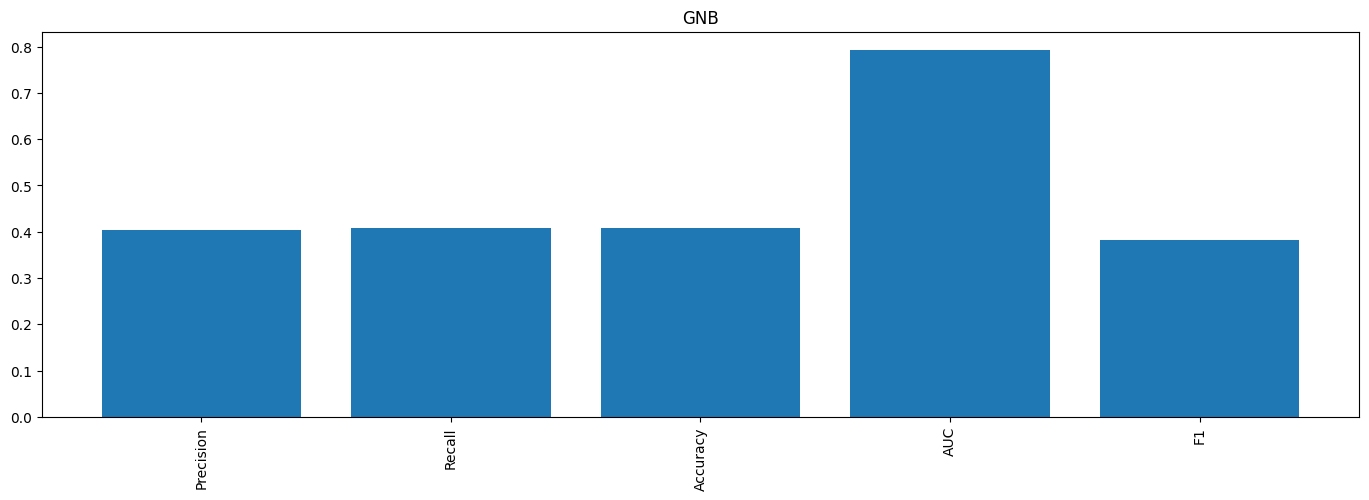

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

clf_GB = GaussianNB()
label_binarizer = LabelBinarizer()


# Addestramento del classificatore
clf_GB.fit(X_train, y_train)

# Predizione delle classi per i dati di test
y_pred = clf_GB.predict(X_train)
y_pred_proba=clf_GB.predict_proba(X_train)

accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average='macro')
precision = precision_score(y_train, y_pred,average='macro')
recall = recall_score(y_train, y_pred,average='macro')

true_labels_binary = label_binarizer.fit_transform(y_train)
roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

metrics_best = []
metrics_best.append(precision)
metrics_best.append(recall)
metrics_best.append(accuracy)
metrics_best.append(roc_auc)
metrics_best.append(f1)

plt.bar(metrics, metrics_best)
plt.title("GNB")
plt.xticks(rotation=90)
plt.show()





Tale modello mostra tutte le metriche peggiori rispetto al miglior modello SVM. Dopo aver osservato le metriche è possibile visualizzare gli errori commessi dal classificatore attraverso la matrice di confusione. Questo modello così come SVM riconosce discretamente bene Hip-Hop e Folk. Al contrario del precedente riconosce peggio Electronic e Instrumental.

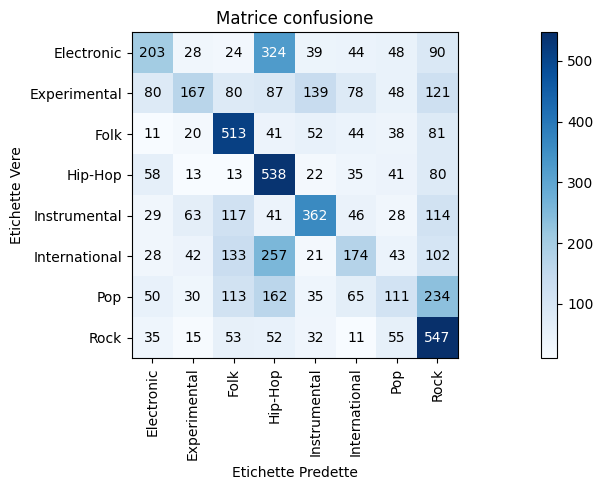

In [18]:
plot_matrix_confusion(clf_GB,X_train,y_train,"Matrice confusione")

### Random forest

Un classificatore Random Forest è un algoritmo di machine learning che si basa sull'idea di combinare diversi alberi decisionali per la classificazione. È una tecnica di apprendimento ensemble, in cui più modelli (alberi decisionali) vengono addestrati e i loro risultati vengono combinati per ottenere una previsione finale.

Per questo modello di classificazione la model selection si basa sulla scelta di 4 parametri : criterion, profondità massima di un albero decisionale, numero di stimatori e il numero massimo di features da considerare. La ricerca è "brute force" limitata, nel senso che si provano un sottoinsieme di combinazione di questi parametri e si va a scegliere il modello che massimizza l'accuratezza. 

In scikit-learn (sklearn), il parametro "criterion" indica la funzione utilizzata per misurare la qualità di una suddivisione durante la creazione degli alberi decisionali.

Il parametro "criterion" può essere impostato su tre valori principali:

1. **gini**:
    Se si imposta criterion="gini", viene utilizzato l'indice di Gini come criterio per la suddivisione dei nodi durante la costruzione degli alberi decisionali. L'indice di Gini misura la purezza delle divisioni, valutando la probabilità che un elemento selezionato casualmente venga classificato erroneamente dopo essere stato assegnato a un sottoinsieme. Minimizzare l'indice di Gini corrisponde a massimizzare la purezza delle divisioni.

    $$H=\sum_{i=1}^{n} p_i(1-p_i)$$

2. **entropy**:
    Se si imposta criterion="entropy", viene utilizzata l'entropia come criterio per la suddivisione dei nodi. L'entropia misura il disordine o l'incertezza all'interno di un insieme di dati. Minimizzando l'entropia, si cerca di massimizzare l'informazione guadagnata attraverso la suddivisione dei nodi.

    $$H=-\sum_{i=1}^{n} p_ilog(p_i)$$




L'immagine seguente mostra alcuni risultati della ricerca brute force e mostra come sono evolute le prestazioni al variare del criterion. Si puo notare come il criterion non influenzi eccessivamente l'accuratezza del modello finale, sia giny che entropy che loss, raggiungono prestazioni che sono tra loro paragonabili.

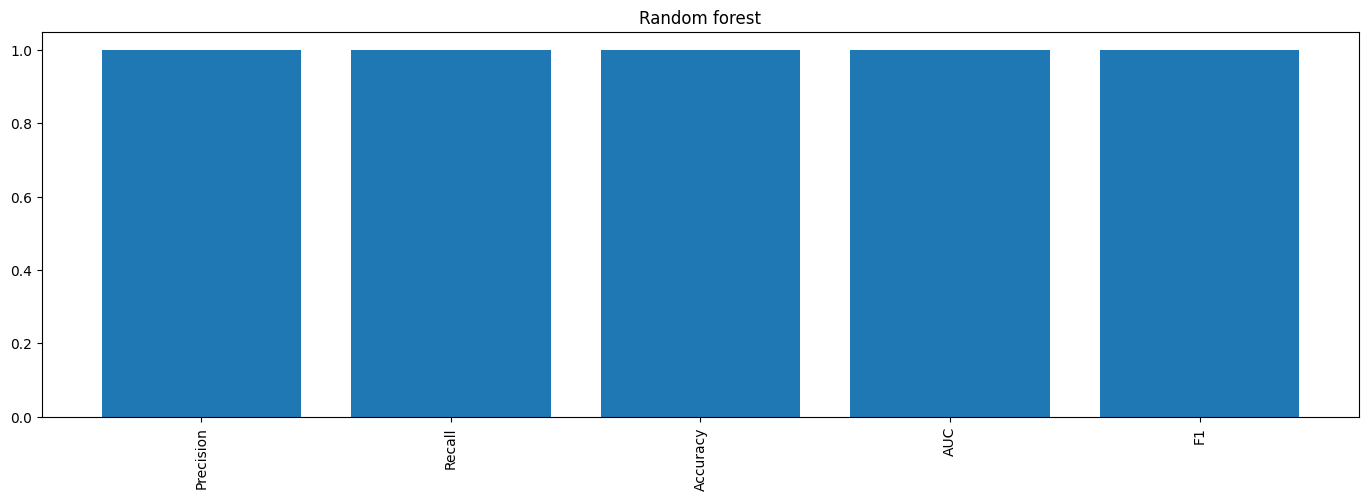

In [48]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

nomi_colonne = ['criterio', 'max_depth', 'n_estimators','max_features','precision','recall','accuracy','f1','AUC']
df = pd.DataFrame(columns=nomi_colonne)
label_binarizer = LabelBinarizer()


to_plot = []
label_to_plot = []
all_criteria = ['gini', 'entropy']

best_acc=0
best_max_depth=0
best_n_estimators=0
best_max_features=0
best_criterion=""
clf_best_RF = None

for criteria in all_criteria:
    to_plot = []
    label_to_plot = []
    best_acc=0
    for i in range(1,20,1):
        for j in range(1,20,1):
            for k in range(20,100,5):
                clf = RandomForestClassifier(max_depth=i, n_estimators=j, max_features=k,criterion=criteria)

                # Addestramento del classificatore
                clf.fit(X_train, y_train)

                y_pred = clf.predict(X_train)
                y_pred_proba = clf.predict_proba(X_train)

                accuracy = accuracy_score(y_train, y_pred)
                f1 = f1_score(y_train, y_pred, average='macro')
                precision = precision_score(y_train, y_pred,average='macro')
                recall = recall_score(y_train, y_pred,average='macro')

                true_labels_binary = label_binarizer.fit_transform(y_train)
                roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

                
                if accuracy > best_acc:
                    metrics_best = []
                    metrics_best.append(precision)
                    metrics_best.append(recall)
                    metrics_best.append(accuracy)
                    metrics_best.append(roc_auc)
                    metrics_best.append(f1)
                    clf_best_RF = copy.deepcopy(clf)
                    best_acc = accuracy

                
                new_row = {
                    'criterio': criteria,
                    'max_depth': i,
                    'n_estimators': j,
                    'max_features': k,
                    'precision': precision,
                    'recall': recall,
                    'accuracy': accuracy,
                    'f1': f1,
                    'AUC': roc_auc
                }

                df.loc[len(df)] = new_row
                df.to_csv("RF.csv")




plt.bar(metrics, metrics_best)
plt.title("Random forest")
plt.xticks(rotation=90)
plt.show()

Il modello migliore registra le segenti prestazioni : precision = 1, recall = 1, Accuracy = 1 , AUC = 10.72 , f1 = 1.

Random forest è il miglior modello trovato fino ad ora. Il fatto che tutte le metriche siano 1 fa però pensare ci sia un problema di overfitting. Come si può notare anche dalla matrice di confusione tutte le classi vengono riconosciute correttamente.

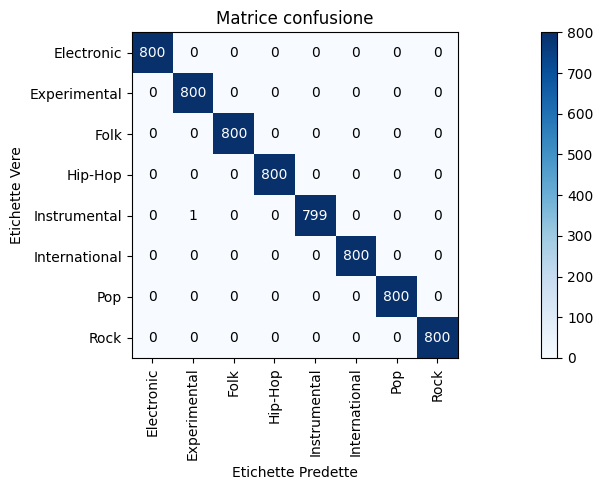

In [20]:
plot_matrix_confusion(clf_best_RF,X_train,y_train,"Matrice confusione")

Il seguente grafico mostra come le metriche di precisione, accuratezza e f1 variano al variare della dimensione del comitato. Si può osservare come all'aumentare delle dimensioni dell'ensambe le metriche tendano a migliorare progressivamente.

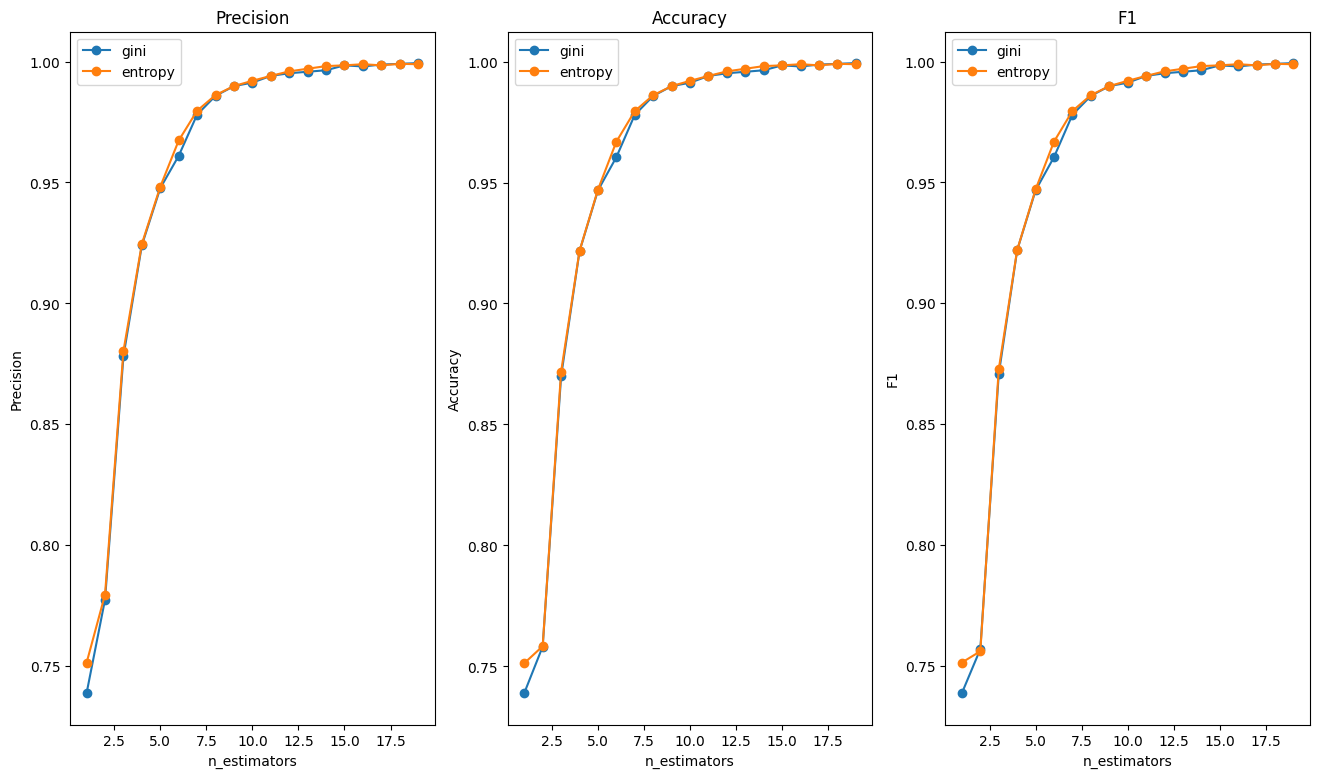

In [49]:

df_gini = df[ (df['criterio'] == "gini") ] 
df_entropy = df[ (df['criterio'] == "entropy")]

f, axarr = plt.subplots(1,3,figsize=(16, 9))

axarr[0].set_title("Precision")
axarr[0].set_xlabel("n_estimators")
axarr[0].set_ylabel("Precision")
axarr[0].plot(df_gini['n_estimators'],df_gini['precision'], '-o', label = "gini")
axarr[0].plot(df_entropy['n_estimators'],df_entropy['precision'], '-o', label = "entropy")
axarr[0].legend()

axarr[1].set_title("Accuracy")
axarr[1].set_xlabel("n_estimators")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(df_gini['n_estimators'],df_gini['accuracy'], '-o', label = "gini")
axarr[1].plot(df_entropy['n_estimators'],df_entropy['accuracy'], '-o', label = "entropy")
axarr[1].legend()

axarr[2].set_title("F1")
axarr[2].set_xlabel("n_estimators")
axarr[2].set_ylabel("F1")
axarr[2].plot(df_gini['n_estimators'],df_gini['f1'], '-o', label = "gini")
axarr[2].plot(df_entropy['n_estimators'],df_entropy['f1'], '-o', label = "entropy")
axarr[2].legend()






### ADA Boost
E' un algoritmo basato sull'approccio di classificazione ensambe. L'idea è quella di addestrare più modelli in sequenza in modo che ogni modello tenga conto degli errori commesso dal predittore precedente. Ad ogni iterazione si viene a creare un modello che tende a correggere gli errori commessi dai modelli precedenti. La classificazione finale viene tuttavia fatta combinando le predizione di tutti i modelli.

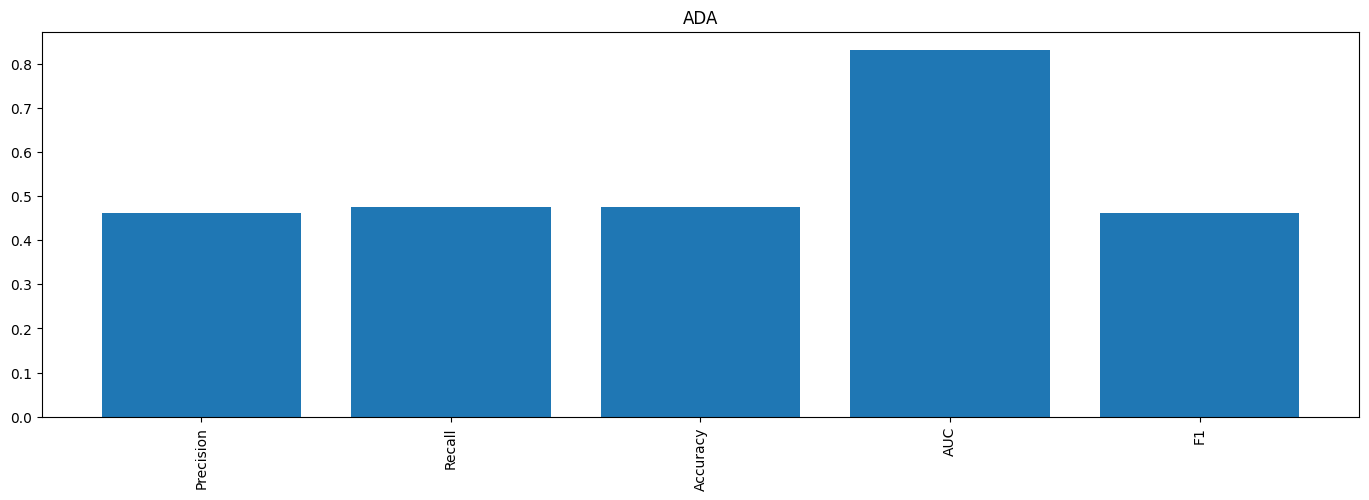

In [23]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': np.arange(40, 60, 2),
    'learning_rate': np.arange(0.5, 1.5, 0.2),
}

nomi_colonne = ['n_estimators', 'learning_rate','precision','recall','accuracy','f1','AUC']
df_ADA = pd.DataFrame(columns=nomi_colonne)

metrics_best = []

label_binarizer = LabelBinarizer()
clf_best_ADA = None

best_accuracy = 0
best_precision = 0
best_recall = 0
best_AUC = 0
best_F1 = 0


for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
      
        # Support vector classification.
        clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
        clf.fit(X_train, y_train)

        y_pred=clf.predict(X_train)
        y_pred_proba=clf.predict_proba(X_train)
        
        accuracy = accuracy_score(y_train, y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        precision = precision_score(y_train, y_pred,average='macro')
        recall = recall_score(y_train, y_pred,average='macro')

        true_labels_binary = label_binarizer.fit_transform(y_train)
        roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

        if accuracy>best_accuracy:
            metrics_best = []
            metrics_best.append(precision)
            metrics_best.append(recall)
            metrics_best.append(accuracy)
            metrics_best.append(roc_auc)
            metrics_best.append(f1)
            clf_best_ADA = copy.deepcopy(clf)
            best_accuracy = accuracy


        new_row = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'f1': f1,
            'AUC': roc_auc
        }

        df_ADA.loc[len(df_ADA)] = new_row
        df_ADA.to_csv("ADA.csv")


plt.bar(metrics, metrics_best)
plt.title("ADA")
plt.xticks(rotation=90)
plt.show()



Tale modello risulta essere il secondo peggiore dopo GNB. Le metriche calcolate sono tutte migliori di GNB ma tutte peggiori degli altri modelli addestrati. Osservando la matrice di confusione si può notare come gli errori commessi siano del tutto paragonabili a GNB. Infatti entrambi i modelli riconoscono discretamente bene le classi Hip-Hop e Rock e il folk. A differenza di GNB, ADA boost riesce a riconoscere molto bene anche l'instrumental e l'electronic.

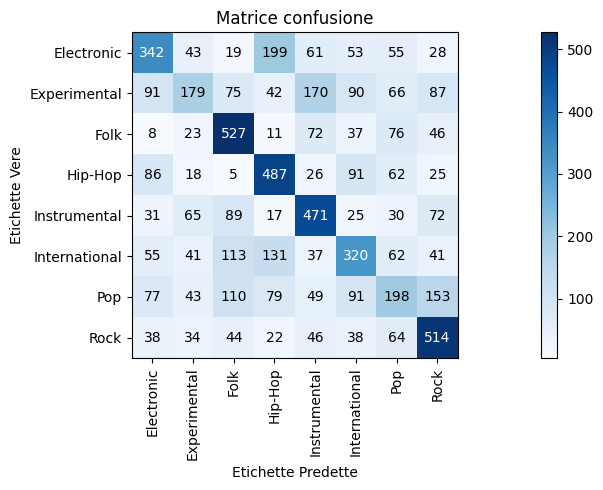

In [24]:
plot_matrix_confusion(clf_best_ADA,X_train,y_train,"Matrice confusione")

L'immagine seguenta mostra come le metriche di precisione, accuratezza e f1 variano al variare della dimensione del comitato. Si osserva come le metriche migliorano progressivamente all'aumentare del numero di stimatori.

Text(0, 0.5, 'F1')

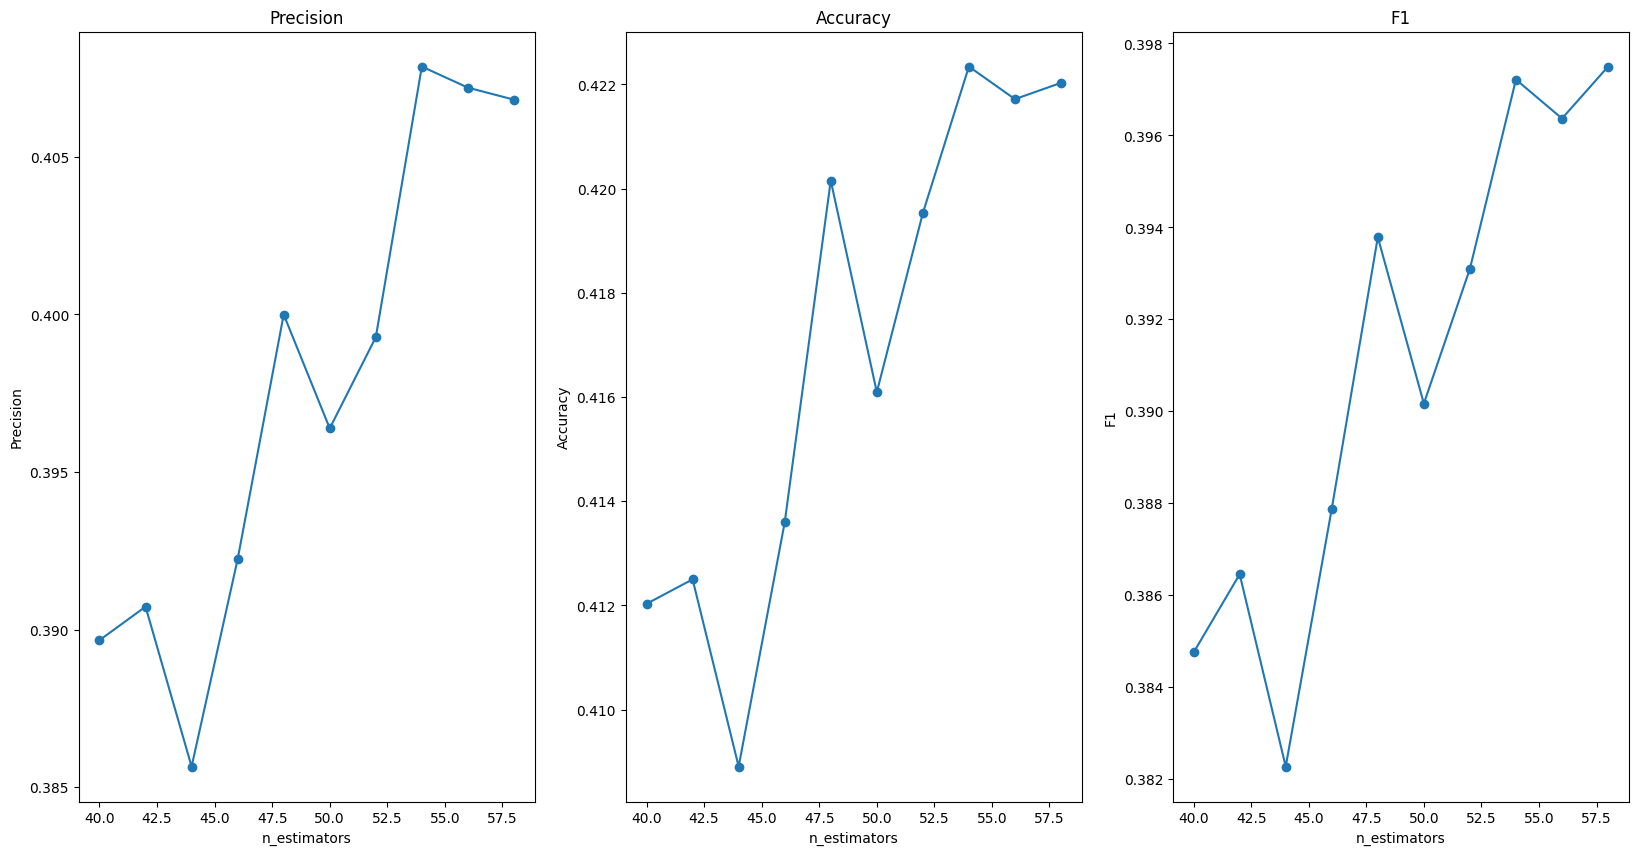

In [25]:

df_filter = df_ADA[ (df_ADA['learning_rate'] > 1.1) ] 
f, axarr = plt.subplots(1,3,figsize=(20, 10))

axarr[0].set_title("Precision")
axarr[0].plot(df_filter['n_estimators'],df_filter['precision'], '-o')
axarr[0].set_xlabel("n_estimators")
axarr[0].set_ylabel("Precision")

axarr[1].set_title("Accuracy")
axarr[1].plot(df_filter['n_estimators'],df_filter['accuracy'], '-o')
axarr[1].set_xlabel("n_estimators")
axarr[1].set_ylabel("Accuracy")

axarr[2].set_title("F1")
axarr[2].plot(df_filter['n_estimators'],df_filter['f1'],'-o')
axarr[2].set_xlabel("n_estimators")
axarr[2].set_ylabel("F1")




### KNN
Il k-nearest neighbors abbreviato in K-NN, è un algoritmo utilizzato nel riconoscimento di pattern per la classificazione basandosi sulle caratteristiche degli oggetti vicini a quello considerato. In entrambi i casi, l'input è costituito dai k esempi di addestramento più vicini nello spazio delle funzionalità. Si tratta di un approccio di classificazione non parametrico.

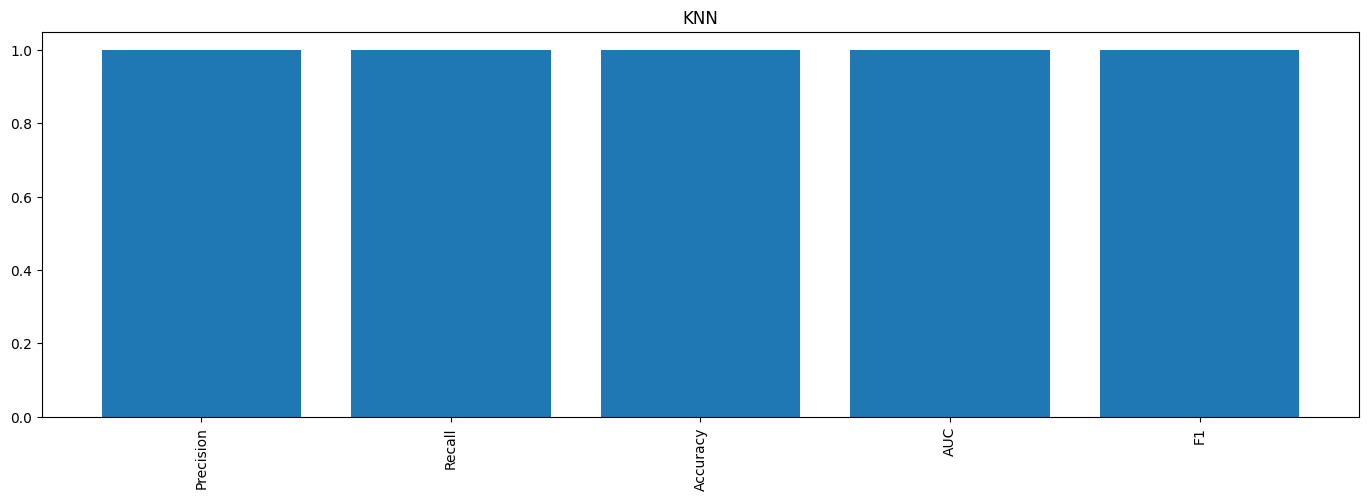

In [26]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': np.arange(1, 95, 1),
    'weights':{"uniform", "distance"}
}

nomi_colonne = ['n_neighbors', 'weights','precision','recall','accuracy','f1','AUC']
df_KNN = pd.DataFrame(columns=nomi_colonne)
metrics_best = []

label_binarizer = LabelBinarizer()
clf_best_KNN = None

best_accuracy = 0
best_precision = 0
best_recall = 0
best_AUC = 0
best_F1 = 0


for n_neighbor in param_grid['n_neighbors']:
    for weight in param_grid['weights']:
      
        # Support vector classification.
        clf = KNeighborsClassifier(n_neighbors=n_neighbor, weights=weight)
        clf.fit(X_train, y_train)

        y_pred=clf.predict(X_train)
        y_pred_proba=clf.predict_proba(X_train)
        
        accuracy = accuracy_score(y_train, y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        precision = precision_score(y_train, y_pred,average='macro')
        recall = recall_score(y_train, y_pred,average='macro')

        true_labels_binary = label_binarizer.fit_transform(y_train)
        roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

        if accuracy>best_accuracy:
            metrics_best = []
            metrics_best.append(precision)
            metrics_best.append(recall)
            metrics_best.append(accuracy)
            metrics_best.append(roc_auc)
            metrics_best.append(f1)
            clf_best_KNN = copy.deepcopy(clf)
            best_accuracy = accuracy

        new_row = {
            'n_neighbors': n_neighbor,
            'weights': weight,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'f1': f1,
            'AUC': roc_auc
        }

        df_KNN.loc[len(df_KNN)] = new_row
        df_KNN.to_csv("KNN.csv")

        
plt.bar(metrics, metrics_best)
plt.title("KNN")
plt.xticks(rotation=90)
plt.show()



Osservando tali metriche si può vedere come KNN sia il secondo miglior modello: al pari di Random forest infatti le matriche raggiungono il valore massimo. Tuttavi anche in questo caso è evidente un problema di overfitting.


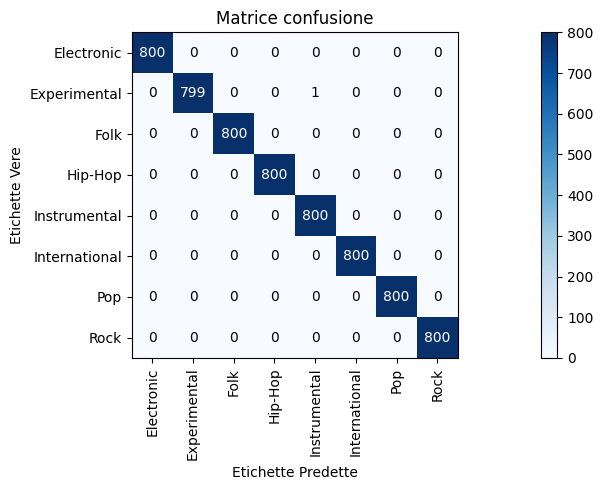

In [27]:
plot_matrix_confusion(clf_best_KNN,X_train,y_train,"Matrice confusione")

L'immagine seguente mostra come le metriche di precisione, accuratezza e f1 variano al variare del numero di vicini considerati. Nelle immagini è mostrato il confronto tra due diversi modelli: uno che pesa i k vicini in modo uniforme e un altro che pesa i k vicini in maniera proporzionale alla distanza. Si noti come il secondo modello tende ad andare in overfitting anche per valori piccoli i k. Per il primo modello si osserva invece che il miglior valore di k che ottimizza le metriche è k=1.

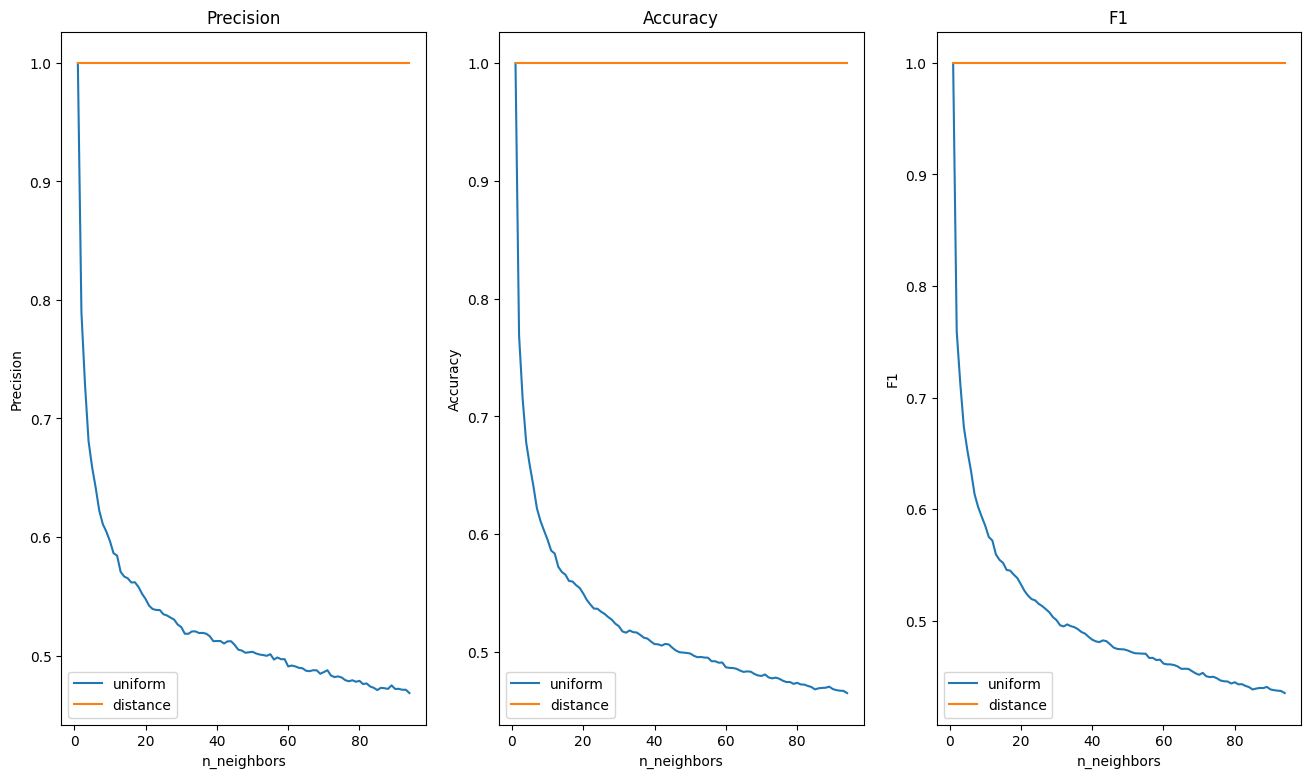

In [50]:

df_uniforme = df_KNN[ (df_KNN['weights'] == "uniform") ] 
df_distance = df_KNN[ (df_KNN['weights'] == "distance")]

f, axarr = plt.subplots(1,3,figsize=(16, 9))

axarr[0].set_title("Precision")
axarr[0].set_xlabel("n_neighbors")
axarr[0].set_ylabel("Precision")
axarr[0].plot(df_uniforme['n_neighbors'],df_uniforme['precision'],label="uniform")
axarr[0].plot(df_distance['n_neighbors'],df_distance['precision'],label="distance")
axarr[0].legend()

axarr[1].set_title("Accuracy")
axarr[1].set_xlabel("n_neighbors")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(df_uniforme['n_neighbors'],df_uniforme['accuracy'],label="uniform")
axarr[1].plot(df_distance['n_neighbors'],df_distance['accuracy'],label="distance")
axarr[1].legend()


axarr[2].set_title("F1")
axarr[2].set_xlabel("n_neighbors")
axarr[2].set_ylabel("F1")
axarr[2].plot(df_uniforme['n_neighbors'],df_uniforme['f1'],label="uniform")
axarr[2].plot(df_distance['n_neighbors'],df_distance['f1'],label="distance")
axarr[2].legend()

plt.show()




### Confornto classificatori
Questa sezione si occupa di confrontare i migliori modelli trovati. La ricerca del predittore migliore è stata effettuata usando i dati di training. Il confronto si basa invece sui dati di test.

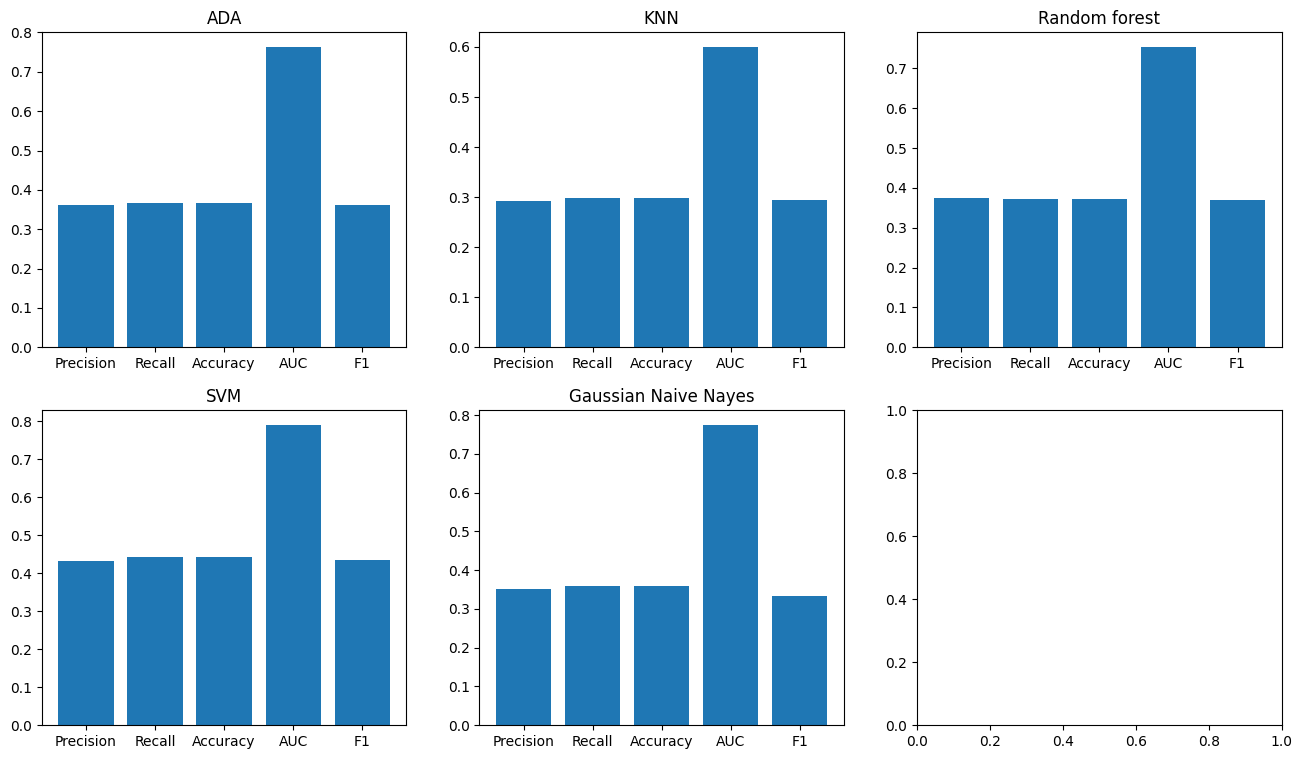

In [51]:

all_classifier = [clf_best_ADA,clf_best_KNN,clf_best_RF,clf_best_SVM,clf_GB]
name_classifier = ["ADA", "KNN", "Random forest", "SVM", "Gaussian Naive Nayes"]
metrics_best = []
 
f, axarr = plt.subplots(2,3,figsize=(16, 9))
all_pos_to_plot = [[0,0],[0,1],[0,2],[1,0],[1,1]]


for index,(clf,name) in enumerate(zip(all_classifier,name_classifier)):
 
    y_pred=clf.predict(X_test)
    y_pred_proba=clf.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred,average='macro')
    recall = recall_score(y_test, y_pred,average='macro')

    true_labels_binary = label_binarizer.fit_transform(y_test)
    roc_auc = roc_auc_score(true_labels_binary, y_pred_proba,average='macro', multi_class="ovr")

    metrics_best = []
    metrics_best.append(precision)
    metrics_best.append(recall)
    metrics_best.append(accuracy)
    metrics_best.append(roc_auc)
    metrics_best.append(f1)

    pos_to_plot = all_pos_to_plot[index]
    axarr[pos_to_plot[0]][pos_to_plot[1]].bar(metrics, metrics_best)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(name)



SVM si conferma il modello migliore, in accordo con le analisi effettuate con i dati di training. In opposizione invece con le metriche calcolate in precedenza, KNN registra prestazioni pessime. Con i dati di test diventa addirittura il peggior modello accompagnato da ADA Boost. GNB e RF hanno invece prestazioni che sono paragonabili. In particolare GNB registra un valore di AUC più alto ma tutte le altre metriche sono leggermente maggiori per RF.

## Seconda sezione
Un suono può essere descritto attraverso la variazione di pressione dell'aria nel tempo.  Per rappresentare digitalmente un audio è necessario prelevare campioni della pressione al variare del tempo. La velocità con cui sono campionati i dati può variare in base al contesto, ma più comunemente è 44,1 kHz o 44.100 campioni al secondo. Quello che si cattura in questo modo è una forma d'onda, e questa può essere interpretata, modificata e analizzata con un software.

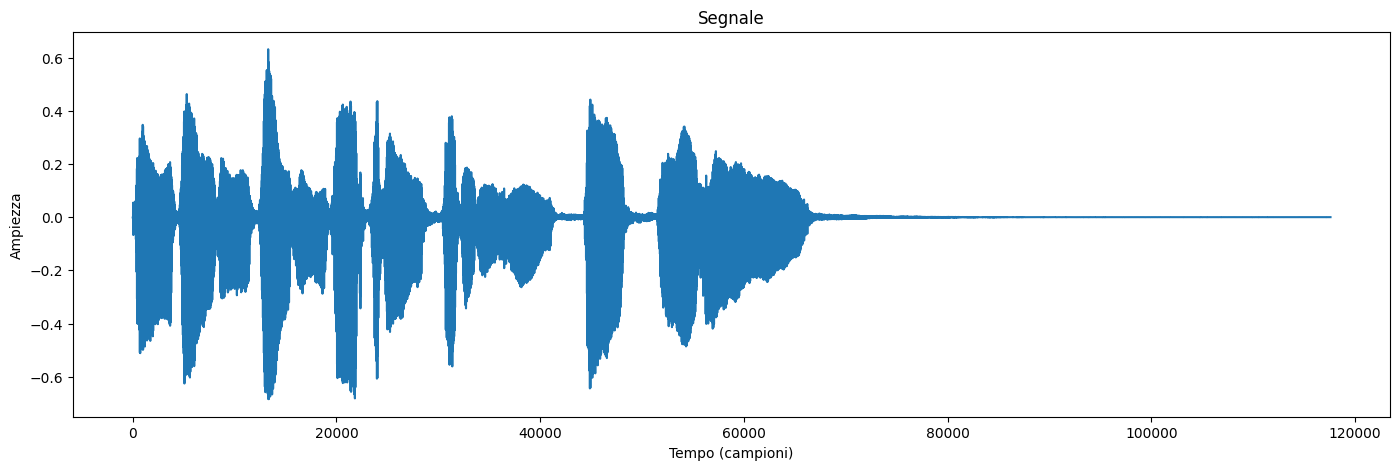

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import librosa 
import librosa.display 

y, sr = librosa.load(librosa.ex('trumpet'))

plt.plot(y); 
plt.title('Segnale'); 
plt.xlabel('Tempo (campioni)'); 
plt.ylabel('Ampiezza');

Un segnale audio è composto da diverse onde sonore a singola frequenza che si sovrappongo tra loro. Quando si prende un campione del segnale nel tempo, si catturano solo le ampiezze risultanti della sovrapposizione. La trasformata di Fourier è una formula matematica che permette di scomporre un segnale nelle sue singole frequenze. In altre parole, converte il segnale dal dominio del tempo nel dominio della frequenza. Il risultato è chiamato spettro .

![1_xTYCtcx_7otHVu-uToI9dA.webp](https://miro.medium.com/v2/resize:fit:828/format:webp/1*xTYCtcx_7otHVu-uToI9dA.png)

Il codice seguente mostra la conversione di un segnale dal dominio del tempo a quello della frequenza.

Text(0, 0.5, 'Ampiezza')

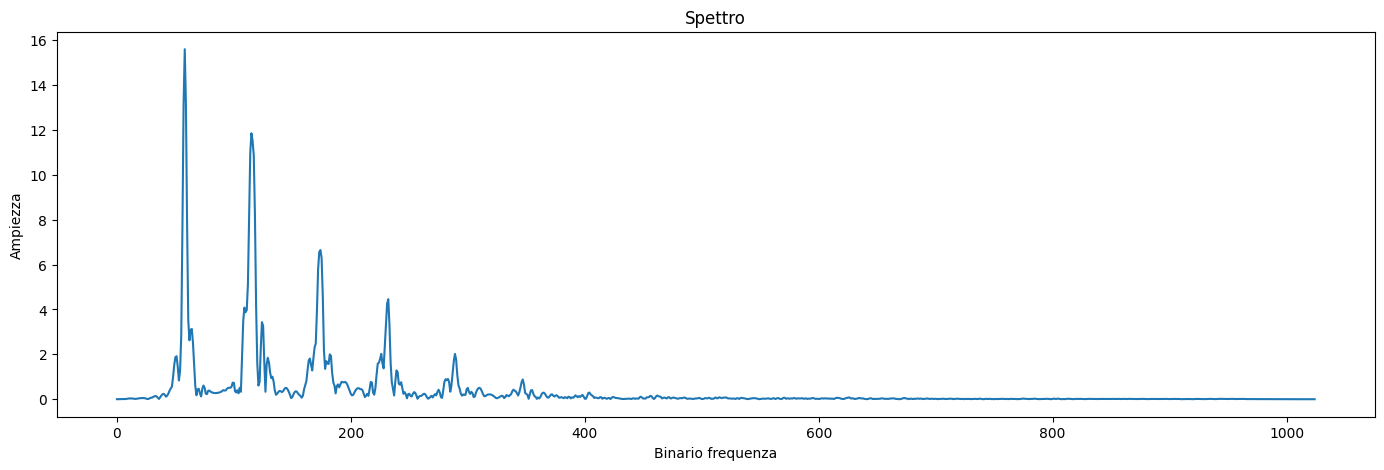

In [32]:
import numpy as np
n_fft = 2048 
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))
plt.plot(ft); 
plt.title('Spettro')
plt.xlabel('Binario frequenza')
plt.ylabel('Ampiezza')

La trasformata veloce di Fourier è un potente strumento che consente di analizzare il contenuto in frequenza di un segnale, ma cosa succede se il contenuto in frequenza del nostro segnale varia nel tempo? Questo è il caso della maggior parte dei segnali audio come la musica e il parlato. Questi segnali sono noti come segnali non periodici . C'è bisogno di un modo per rappresentare lo spettro di questi segnali mentre variano nel tempo. Per fare questo è utilizzata la trasformata di Fourier di breve durata. La FFT viene calcolata sulla sovrapposizione di segmenti finestrati del segnale: quello che si ottiene viene chiamato spettrogramma.

![1_tIBRdtG3EfjmSIlraWVIxw.webp](https://miro.medium.com/v2/resize:fit:828/format:webp/1*tIBRdtG3EfjmSIlraWVIxw.png)

In un contesto di classificazione supervisionata di generi musicali,l'analisi dello spettrogramma potrebbe essere particolarmente utile per distinguere i vari generi. I dati offerti da FMA sono a tutti gli effetti statistiche come max, min e media calcolate a partire da una pre-elaborazione degli audio. Avere un'immagine che è più ricca e completa completa di una sequenza di statistiche potrebbe essere molto più utile a un classificatore.

Di seguito è riportato uno spettrogramma di un audio calcolatoto tramite la libreria librosa. L'idea è fornire in ingresso a un modello di classificazione proprio immagini di questo tipo.

Text(0.5, 1.0, 'Spettrogramma')

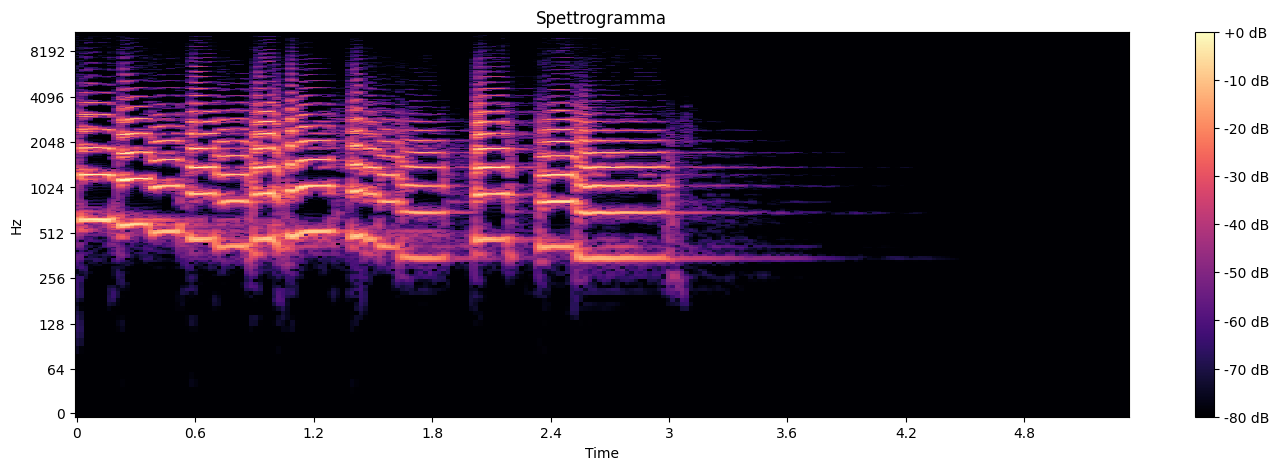

In [33]:
spec = np.abs(librosa.stft(y, hop_length=512)) 
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log') 
plt.colorbar(format='%+2.0f dB')
plt.title('Spettrogramma')

### CNN
Per l'addestramento di CNN l'idea è quella di dare in ingresso al modello di classificazione delle immagini generate a partire dagli spettrogrammi degli audio. L'idea si basa sul fatto che il dataset a disposizione contiene solo alcune statistiche descrittive, come media varianza moda. In questo modo con un immagine che descrive nel dettaglio la variazione di frequenza dell'audio potrebbe essere più semplice per un modello di predizione realizzare la classificazione. Si consideri inoltre che le reti convoluzionari funzionano molto bene nella classificazione di immagini. Il pezzo di codice seguente serve appunto per convertire un audio in uno settrogramma e salvarlo con un immagine a scala di grigi. 

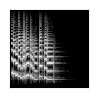

In [34]:
y, sr = librosa.load(librosa.ex('trumpet'))
librosa.feature.melspectrogram(y=y, sr=sr)
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
fig.set_size_inches(1, 1)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr,fmax=8000, ax=ax,cmap='gray')
plt.savefig("out.png",dpi=80,bbox_inches='tight', pad_inches=0)


Si ossercvi più nel dettaglio l'immagine generata. L'mmagine che è di 80 pixel*80 pixel. L'immagine è generata in modo che ad ogni pixel venga assegnato un numero in base alla gradazione della scala di grigi.

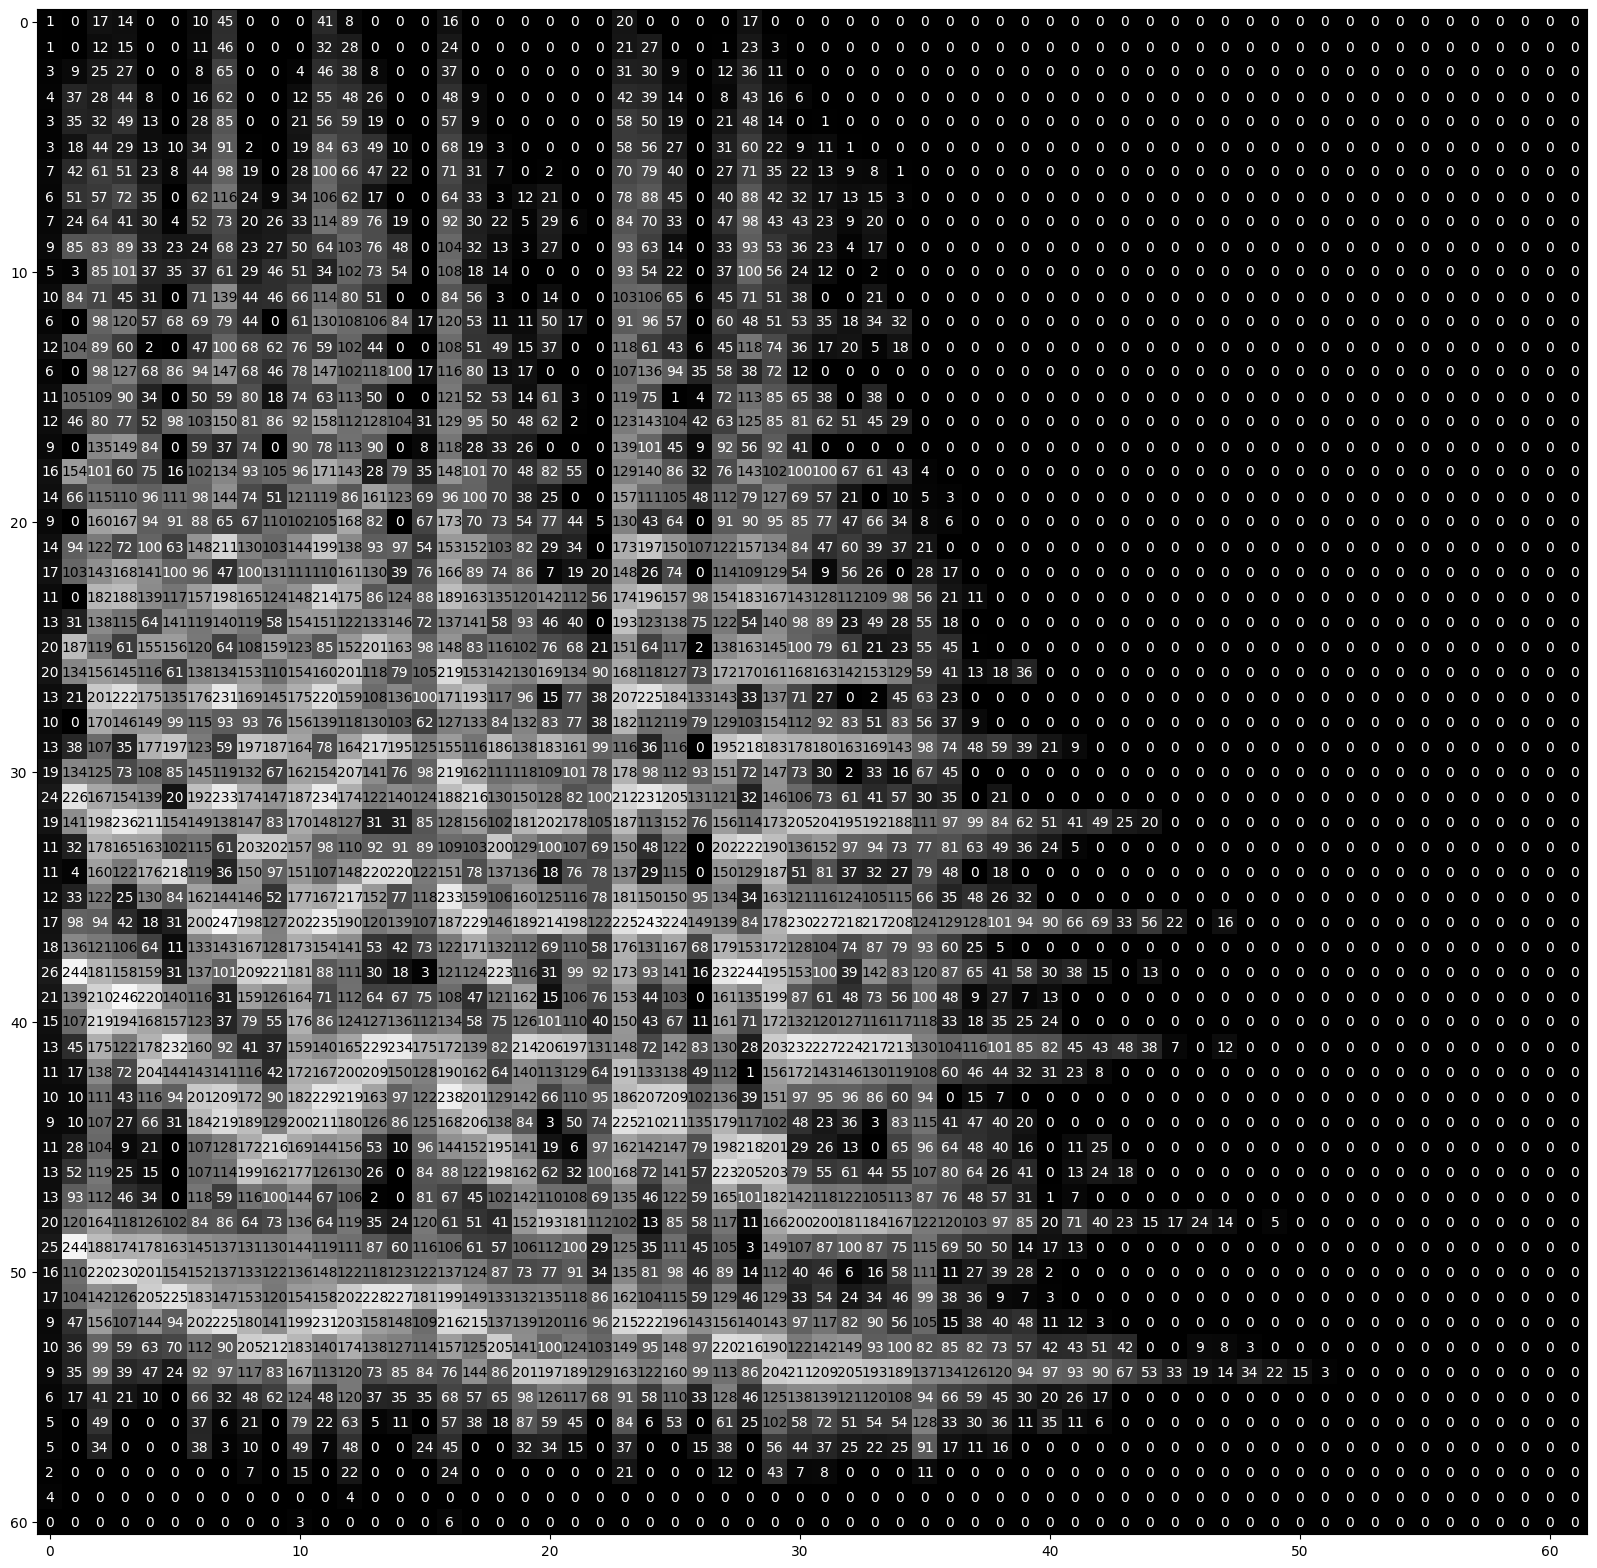

In [35]:
from PIL import Image
from numpy import array
im_1 = Image.open(r"out.png")
ar = array(im_1)
img = np.squeeze(ar)

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height,z = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = img[x][y][0] if img[x][y][0] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y][0]<thresh else 'black')

Si generano adesso due diverse reti neurali. Entrambe le reti sono caratterizzate da due layer convoluzionali. La prima rete è però caratterizzata da un solo layer full connected , la seconda da due layer. La dimensione di ogni layer può essere configurata al momento della creazione.

In [36]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self,dim_layer_1):
        super(CNN, self).__init__()

        # Definizione dei livelli convoluzionali
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calcolo delle dimensioni dell'output dopo i livelli convoluzionali
        self.flat_size = 32 * 7 * 7
        
        # Livelli fully connected
        self.fc1 = nn.Linear(self.flat_size, dim_layer_1)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(dim_layer_1, 8)
    
    def forward(self, x):
        # Passaggio dei dati attraverso i livelli convoluzionali
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # Flattening dell'output per i livelli fully connected
        x = x.view(-1, self.flat_size)
        
        # Passaggio attraverso i livelli fully connected
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

class CNN_2Layer(nn.Module):
    def __init__(self,dim_layer_1,dim_layer_2):
        super(CNN_2Layer, self).__init__()

        # Definizione dei livelli convoluzionali
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calcolo delle dimensioni dell'output dopo i livelli convoluzionali
        self.flat_size = 32 * 7 * 7
        
        # Livelli fully connected
        self.fc1 = nn.Linear(self.flat_size, dim_layer_1)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(dim_layer_1, dim_layer_2)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(dim_layer_2, 8)


    
    def forward(self, x):
        # Passaggio dei dati attraverso i livelli convoluzionali
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # Flattening dell'output per i livelli fully connected
        x = x.view(-1, self.flat_size)
        
        # Passaggio attraverso i livelli fully connected
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        
        return x

    



Si definiscono i metodi per testare e per addestrare le reti.

In [37]:
from sklearn.preprocessing import LabelEncoder
from torch import optim

num_epochs = 10

def train(num_epochs, cnn, train_loader):
    
  optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  cnn.to(device)
  cnn.train()
  
  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)
      
  for epoch in range(num_epochs):
    for images, labels in train_loader:
      
      labels = torch.tensor(labels).to(device)
      images = images.to(device)
      
      outputs = cnn(images)
      
      loss = loss_func(outputs, labels)
      
      # clear gradients for this training step   
      optimizer.zero_grad()           
      
      # backpropagation, compute gradients 
      loss.backward()    
      # apply gradients             
      optimizer.step()  

                      
      

In [38]:
def test(model, dataloader):
    model.eval()  # Impostazione del modello in modalità valutazione
    
    corretti = 0
    totali = 0
    
    with torch.no_grad():
        for immagini, etichette in dataloader:
           
            output = model(immagini)
            _, predizioni = torch.max(output, 1)
            
            totali +=len(etichette)

            for i in range(len(predizioni)):
                if(predizioni[i]==etichette[i]):
                    corretti=corretti+1

    
    accuratezza = 100.0 * corretti / totali
    return accuratezza

### CNN 1 layer
Si procede a ricercare il miglior modello avente un solo layer full connected. La ricerca consiste nel testare diverse dimensioni del layer. La rete migliore sarà quella avente accuratezza più alta. 

In [39]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

# Carica il training set dal file npz
dataset_imm = np.load("training\\training_set.npz")
imgs = dataset_imm["immagini"]
labels = dataset_imm["etichette"]

# Crea un oggetto LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Crea una trasformazione ToTensor
transform = transforms.ToTensor()

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)

#Creo dataset
dataset_train = MyCustomDataset(X_train, y_train,transform)
dataset_test = MyCustomDataset(X_test, y_test,transform)

# Crea un DataLoader per il dataset di addestramento
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

best_acc = 0
best_dim = 0

for dim_layer_1 in [16,32,48,64,80,96,128]:
    cnn = CNN(dim_layer_1)

    train(10,cnn,train_loader)
    acc = test(cnn,test_loader)

    if acc>best_acc:
        best_dim= dim_layer_1
        best_acc = acc
    
    print(acc)

print("Modello migliore: accuratezza = {}, layer 1 = {}".format(best_acc,best_dim))


30.107526881720432
38.70967741935484
39.784946236559136
49.46236559139785
40.86021505376344
50.53763440860215
48.38709677419355
Modello migliore: accuratezza = 50.53763440860215, layer 1 = 96


### CNN 2 layer
Si procede a ricercare il miglior modello avente due layer full connected. La ricerca consiste nel provare varie dimensione dei due layer effettuando una ricerca a griglia. Ancora una volta il modello migliore sarà quello che registra accuratezza maggiore.

In [40]:
best_acc = 0
best_dim_1 = 0
best_dim_2 = 0


for dim_layer_1 in [16,32,48,64,80,96,128]:
    for dim_layer_2 in [16,32,48,64,80,96,128]:

        cnn2 = CNN_2Layer(dim_layer_1,dim_layer_2)

        train(10,cnn2,train_loader)
        acc = test(cnn2,test_loader)

        if acc>best_acc:
            best_dim_1= dim_layer_1
            best_dim_2= dim_layer_2
            best_acc = acc
        
        print(acc)

print("Modello migliore: accuratezza = {}, layer 1 = {}, layer 2 = {}".format(best_acc,best_dim_1,best_dim_2))

30.107526881720432
31.182795698924732
25.806451612903224
47.31182795698925
39.784946236559136
30.107526881720432
30.107526881720432
31.182795698924732
31.182795698924732
34.40860215053763
23.655913978494624
43.01075268817204
38.70967741935484
48.38709677419355
21.50537634408602
25.806451612903224
47.31182795698925
40.86021505376344
34.40860215053763
36.55913978494624
30.107526881720432
37.634408602150536
47.31182795698925
24.731182795698924
21.50537634408602
54.83870967741935
40.86021505376344
50.53763440860215
38.70967741935484
29.032258064516128
39.784946236559136
41.935483870967744
35.483870967741936
47.31182795698925
38.70967741935484
34.40860215053763
46.236559139784944
44.086021505376344
27.956989247311828
41.935483870967744
43.01075268817204
43.01075268817204
34.40860215053763
38.70967741935484
45.16129032258065
30.107526881720432
30.107526881720432
44.086021505376344
40.86021505376344
Modello migliore: accuratezza = 54.83870967741935, layer 1 = 64, layer 2 = 80


Per concludere il progetto si vuole visualizzare quale è l'effetto del primo layer convoluzionale sull'immagine in input. Il layer convoluzionale effettua infatti un'operazione di filtraggio sull'immagine in ingresso nascondendo o evidenziando particolari sezioni. Tale operazione di filtraggio potrebbe aiutare i layer successivi nelle predizioni. Il codice seguente effettua un operazione di convoluzione tra un immagine in input e i kernel convoluzionali delle due reti addestrate. Si può notare come gli effetti della convoluzione siano praticamente gli stessi : si oscura la parte laterale dell'immagine, viene evidenziata la parte centrale e in particolare i pattern di frequenza vengono conservati.

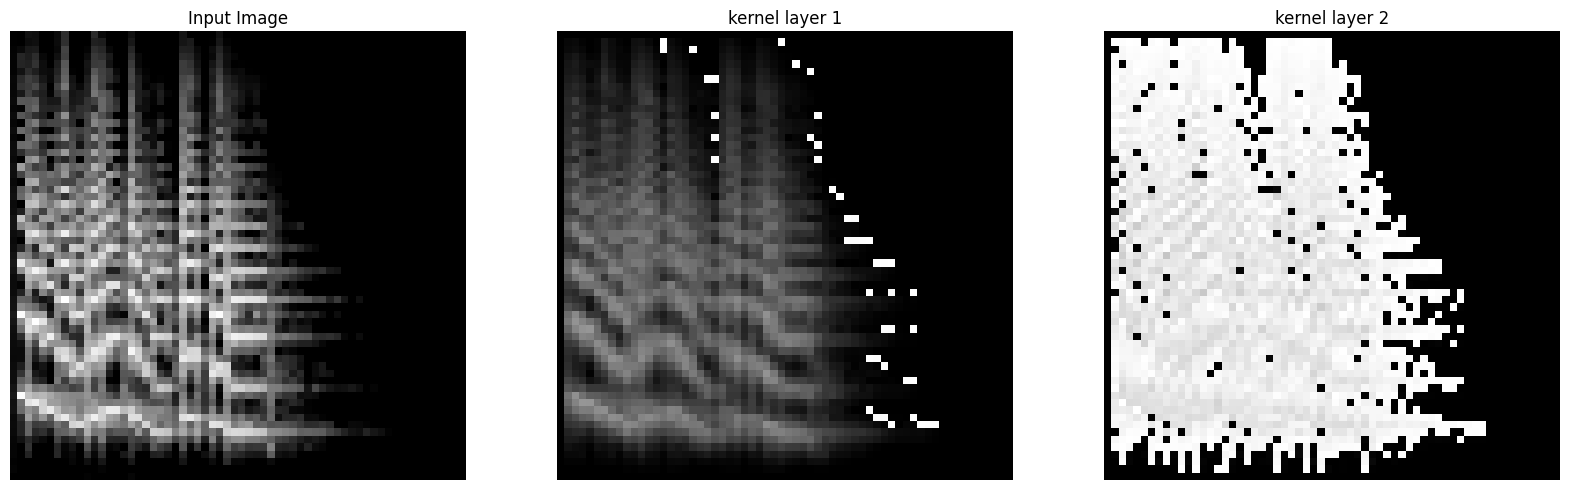

In [41]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Carica l'immagine
img = Image.open(r"out.png")

# Converte l'immagine in scala di grigi
gray_img = img.convert("L")

# Converti l'immagine in un array NumPy
image_array = np.array(gray_img)

all_kernel=[]
all_kernel_name=[]


all_kernel.append(cnn.conv1.weight.detach().numpy()[0][0])
all_kernel.append(cnn2.conv1.weight.detach().numpy()[0][0])


all_kernel_name.append("kernel layer 1")
all_kernel_name.append("kernel layer 2")


f, axarr = plt.subplots(1,3,figsize=(20, 20),sharex=True, sharey=True)
all_pos_to_plot = [1,2]

axarr[0].imshow(gray_img, cmap="gray")
axarr[0].set_title("Input Image")
axarr[0].axis("off")

for id_kernel,kernel in enumerate(all_kernel):
    # Esegui la convoluzione
    output_array = np.zeros_like(image_array)
    image_height = image_array.shape[0]
    image_width = image_array.shape[1]
    kernel_height, kernel_width = kernel.shape
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2

    # Applica la convoluzione
    for i in range(padding_height, image_height - padding_height):
        for j in range(padding_width, image_width - padding_width):
            window = image_array[i - padding_height:i + padding_height + 1,
                                j - padding_width:j + padding_width + 1]
            output_array[i, j] = np.sum(window * kernel)

    # Crea l'immagine di output
    output_image = Image.fromarray(output_array.astype(np.uint8))

    pos_to_plot = all_pos_to_plot[id_kernel]

    # Visualizza l'immagine di input e di output
    axarr[pos_to_plot].imshow(output_image, cmap="gray")
    axarr[pos_to_plot].set_title(all_kernel_name[id_kernel])
    axarr[pos_to_plot].axis("off")
    
plt.show()

